In [ ]:
# parameters
#jai_hanuman

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import pandas as pd
from io import BytesIO

# Setup paths
NOTEBOOK_DIR  = Path.cwd()
PROJECT_ROOT  = NOTEBOOK_DIR.parents[0]
SRC_PATH      = PROJECT_ROOT / "src"
CONFIG_PATH   = PROJECT_ROOT / "configs"
DATA_PATH     = PROJECT_ROOT / "data"

if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

from brfss_risk.utils.data_prep import (
    load_maps,
    apply_domain_maps,
    clean_codes,
    apply_standard_fixes,
    generate_missing_report,
    add_missing_indicators,
    get_selected_cols_from_map
)

from brfss_risk.utils.logger import get_logger, log_event

# Constants
MAP_PATH = CONFIG_PATH / "brfss_2023_column_map.yaml"
RAW_PATH = DATA_PATH / "raw" / "brfss_2023_full.parquet"
SEED = 42

# Setup logger + config
logger = get_logger()
maps   = load_maps(MAP_PATH)


In [104]:
from brfss_risk.utils.data_prep import load_maps, apply_domain_maps

In [125]:
# df_raw = pd.read_parquet(RAW_PATH)
# logger.info(f"Loaded raw BRFSS data with shape {df_raw.shape}")

bucket = "verikai-heart-risk-pipeline"
prefix = raw_s3_key

# prefix = "data/raw_data/"

s3 = boto3.client("s3")

# List files in S3 prefix
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
files = [obj["Key"] for obj in response.get("Contents", []) if obj["Key"].endswith(".parquet")]
latest_file = sorted(files, reverse=True)[0]

# Download and read into DataFrame
obj = s3.get_object(Bucket=bucket, Key=latest_file)
df_raw = pd.read_parquet(BytesIO(obj["Body"].read()))

print("Loaded raw data from:", latest_file)


Loaded raw data from: data/raw_data/brfss_2023_full.parquet


In [127]:
# rename_map = {
#     # ── demographics ──
#     '_AGEG5YR': 'age_group',          'SEXVAR': 'sex',           'EDUCA': 'education',
#     'INCOME3': 'income',             'MARITAL': 'marital_status','_RACEGR3': 'race_ethnicity',
#     # ── lifestyle ──
#     'SMOKE100': 'smoked_100_cigs',   '_RFSMOK3': 'current_smoker_flag',
#     'EXERANY2': 'recent_exercise',   '_TOTINDA': 'meets_activity_guidelines',
#     'ALCDAY4': 'alcohol_days',       '_RFDRHV8': 'heavy_drinker',
#     '_HLTHPL1': 'has_health_insurance',
#     # ── physical / chronic ──
#     '_BMI5': 'bmi_raw',              '_MICHD': 'prev_chd_or_mi', 'DIABETE4': 'diabetes',
#     'CHCSCNC1': 'skin_cancer',       'CHCOCNC1': 'other_cancer', 'ASTHMA3': 'asthma',
#     '_RFHYPE6': 'high_bp_flag',      'BPMEDS1': 'taking_bp_meds', 'CVDSTRK3': 'stroke',
#     'TOLDHI3': 'high_cholesterol',   'CHOLCHK3': 'chol_check_recent',
#     # ── mental & general ──
#     'MENTHLTH': 'mental_unhealthy_days','ADDEPEV3': 'ever_depression_dx',
#     'GENHLTH': 'general_health',     'PHYSHLTH': 'physical_unhealthy_days','DIFFWALK': 'difficulty_walking',
#     # ── healthcare access ──
#     'MEDCOST1': 'cost_prevented_care','CHECKUP1': 'last_checkup','PERSDOC3': 'has_primary_doctor',
#     # ── survey design (keep for weighting) ──
#     '_LLCPWT': 'survey_weight', '_STSTR': 'stratum', '_PSU': 'psu',
#     # ── target ──
#     'CVDINFR4': 'heart_attack'
# }

In [129]:
# Loading maps
maps = load_maps(MAP_PATH)

# Rename + binary encode
df_renamed = apply_domain_maps(df_raw, maps)

SELECTED_COLS = get_selected_cols_from_map(MAP_PATH)
df_sel = df_renamed[SELECTED_COLS].copy()
logger.info(f"Subset to selected {len(SELECTED_COLS)} columns")

# Cleaning ambiguous values in selected columns (excluding age_group, income)
df_clean = df_sel[df_sel['age_group'] != 14]
EXCLUDE_FROM_AMBIG = ["age_group"]
df_clean = clean_codes(df_sel, exclude=EXCLUDE_FROM_AMBIG)

2025-05-11 02:47:39,262 INFO     brfss — Applied rename & binary maps
2025-05-11 02:47:39,391 INFO     brfss — Subset to selected 33 columns
2025-05-11 02:47:40,309 INFO     brfss — Converted ambiguous BRFSS codes to NaN


In [115]:
df_clean = apply_standard_fixes(df_clean)

2025-05-11 02:38:45,553 INFO     brfss — Standardized alcohol and *_unhealthy_days fields


In [117]:
df_clean.shape

(433323, 33)

In [119]:
df_clean.head()

,age_group,sex,education,income,marital_status,race_ethnicity,smoked_100_cigs,current_smoker_flag,recent_exercise,meets_activity_guidelines,...,chol_check_recent,mental_unhealthy_days,ever_depression_dx,general_health,physical_unhealthy_days,difficulty_walking,cost_prevented_care,last_checkup,has_primary_doctor,heart_attack
0,13.0,2.0,5.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0
1,13.0,2.0,5.0,NaN,2.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,2.0
2,13.0,2.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,2.0,0.0,4.0,6.0,1.0,1.0,1.0,1.0,2.0
3,12.0,2.0,5.0,NaN,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,2.0,2.0,1.0,0.0,3.0,1.0,2.0
4,12.0,2.0,5.0,NaN,3.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,1.0,2.0


In [295]:
import os
from pathlib import Path

project_root = Path(os.getcwd()).parent 
output_path = project_root / "reports" / "phase1_missing_report.csv"
os.makedirs(output_path.parent, exist_ok=True)

mv.to_csv(output_path, index=False)

log_event(
    phase="Phase1",
    action="Top Missing Value Features",
    summary_dict={
        "top_missing_pct": mv.head(10).set_index('feature')['pct_missing'].round(5).to_dict()
    }
)

#drop based on threshold
drop_candidates = mv[mv['pct_missing'] > 0.30]['feature'].tolist()
top_missing = mv.head(10)

2025-05-04 22:29:14,345 INFO     brfss — {"timestamp": "2025-05-05T02:29:14.345525", "phase": "Phase1", "action": "Top Missing Value Features", "top_missing_pct": {"taking_bp_meds": 0.59448, "income": 0.45417, "high_cholesterol": 0.12712, "bmi_raw": 0.09354, "heavy_drinker": 0.07575, "chol_check_recent": 0.06104, "alcohol_days": 0.05872, "current_smoker_flag": 0.05322, "smoked_100_cigs": 0.05208, "physical_unhealthy_days": 0.04583}}


In [75]:
TARGET = "heart_attack"
df_clean = df_clean[df_clean[TARGET].notna()]
df_clean[TARGET] = df_clean[TARGET].astype(int)

# Gett both normalized and raw counts
counts = df_clean[TARGET].value_counts(dropna=False).sort_index()
target_counts = counts / counts.sum()
positive_rate = target_counts.get(1, 0)

logger.info(f"{TARGET} distribution: {target_counts.round(3).to_dict()}")
logger.info(f"Target column set to: {TARGET} — shape: {df_clean.shape}")

log_event(
    phase="Phase1",
    action="Cleaned Target Mapping",
    summary_dict={
        "counts": {int(k): int(v) for k, v in counts.items()},
        "positive_rate": round(positive_rate, 4)
    }
)

print(counts)
print(f"Cleaned heart attack rate: {positive_rate:.2%}")

2025-05-04 14:49:15,159 INFO     brfss — heart_attack distribution: {1: 0.054, 2: 0.946}
2025-05-04 14:49:15,160 INFO     brfss — Target column set to: heart_attack — shape: (430755, 33)
2025-05-04 14:49:15,160 INFO     brfss — {"timestamp": "2025-05-04T18:49:15.160650", "phase": "Phase1", "action": "Cleaned Target Mapping", "counts": {"1": 23451, "2": 407304}, "positive_rate": 0.0544}
heart_attack
1     23451
2    407304
Name: count, dtype: int64
Cleaned heart attack rate: 5.44%


In [26]:
import datetime
import os
SNAPSHOT_DIR = "data/derived"
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M")
ts_path     = os.path.join(SNAPSHOT_DIR, f"phase1_subset_{ts}.parquet")
latest_path = os.path.join(SNAPSHOT_DIR, f"phase1_subset_latest.parquet")

df_clean.to_parquet(ts_path, index=False)
df_clean.to_parquet(latest_path, index=False)

log_event(
    phase="Phase1",
    action="Saved final subset parquet",
    summary_dict={"timestamped_path": ts_path, "latest_path": latest_path}
)

print("Phase 1 snapshot saved to:")
print("  ", ts_path)
print("  ", latest_path)

2025-05-04 01:53:34,667 INFO     brfss — {"timestamp": "2025-05-04T05:53:34.667752", "phase": "Phase1", "action": "Saved final subset parquet", "timestamped_path": "data/derived/phase1_subset_20250504_0153.parquet", "latest_path": "data/derived/phase1_subset_latest.parquet"}
Phase 1 snapshot saved to:
   data/derived/phase1_subset_20250504_0153.parquet
   data/derived/phase1_subset_latest.parquet


# --------------------------------------------
# Phase 2 : Cleaning and Mapping
# --------------------------------------------

In [81]:
PHASE1_PATH = Path("../data/derived/phase1_subset_latest.parquet")
assert PHASE1_PATH.exists(), f"File not found: {PHASE1_PATH.resolve()}"

df = pd.read_parquet(PHASE1_PATH)
df.head(3)

,age_group,sex,education,income,marital_status,race_ethnicity,smoked_100_cigs,current_smoker_flag,recent_exercise,meets_activity_guidelines,...,chol_check_recent,mental_unhealthy_days,ever_depression_dx,general_health,physical_unhealthy_days,difficulty_walking,cost_prevented_care,last_checkup,has_primary_doctor,heart_attack
0,13.0,2.0,5.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0
1,13.0,2.0,5.0,NaN,2.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,2.0
2,13.0,2.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,2.0,0.0,4.0,6.0,1.0,1.0,1.0,1.0,2.0


In [83]:
numerical_features = [
    'bmi_raw',
    'mental_unhealthy_days',
    'physical_unhealthy_days',
    'alcohol_days'
]

categorical_features = [
    'age_group', 'sex', 'education', 'income', 'marital_status', 'race_ethnicity',
    'smoked_100_cigs', 'current_smoker_flag', 'recent_exercise', 'meets_activity_guidelines',
    'heavy_drinker', 'has_health_insurance',
    'diabetes', 'skin_cancer', 'other_cancer', 'asthma',
    'high_bp_flag', 'taking_bp_meds', 'stroke', 'high_cholesterol', 'chol_check_recent',
    'ever_depression_dx', 'general_health', 'difficulty_walking',
    'cost_prevented_care', 'last_checkup', 'has_primary_doctor', 'prev_chd_or_mi'
]
target_feature = 'heart_attack'

In [85]:
print("Numerical:", len(numerical_features))
print("Categorical:", len(categorical_features))

# Confirming no mismatch
all_known = numerical_features + categorical_features + [target_feature]
missing = [col for col in df.columns if col not in all_known]
extra = [col for col in all_known if col not in df.columns]

print("Unmatched columns in df:", missing)
print("Unmatched declared columns:", extra)


Numerical: 4
Categorical: 28
Unmatched columns in df: []
Unmatched declared columns: []


In [87]:
# 1. BMI re-scaling
df['bmi'] = (df['bmi_raw'] / 100).replace({0: np.nan})

# 2. Categorical to category dtype
for col in categorical_features:
    df[col] = df[col].astype('category')

# 3. Numerical to float
for col in numerical_features + ['bmi']:
    df[col] = df[col].astype('float32')

# 4. Confirm result
print("Sample BMI values:", df[['bmi_raw', 'bmi']].dropna().head(3))

# 5. Summary logging
log_event(
    phase="Phase2",
    action="BMI scaled + dtype conversion",
    summary_dict={
        "bmi_range": (df['bmi'].min(), df['bmi'].max()),
        "num_categorical": len(categorical_features),
        "num_numerical": len(numerical_features) + 1
    }
)

Sample BMI values:    bmi_raw        bmi
0   3047.0  30.469999
1   2856.0  28.559999
2   2231.0  22.309999
2025-05-04 14:57:48,387 INFO     brfss — {"timestamp": "2025-05-04T18:57:48.387038", "phase": "Phase2", "action": "BMI scaled + dtype conversion", "bmi_range": [12.020000457763672, 99.83999633789062], "num_categorical": 28, "num_numerical": 5}


In [107]:
# 4. Decoding ALCDAY4 (alcohol_days)
def decode_alcohol_days(val):
    if 201 <= val <= 299:
        return val - 200  # actual days
    elif 101 <= val <= 199:
        return round((val - 100) * 4.3, 1)  # weekly * 4.3 weeks/month
    elif val == 888:
        return 0
    else:
        return np.nan

df['alcohol_days_clean'] = df['alcohol_days'].apply(decode_alcohol_days)

# Checking Skewness & Distributions:

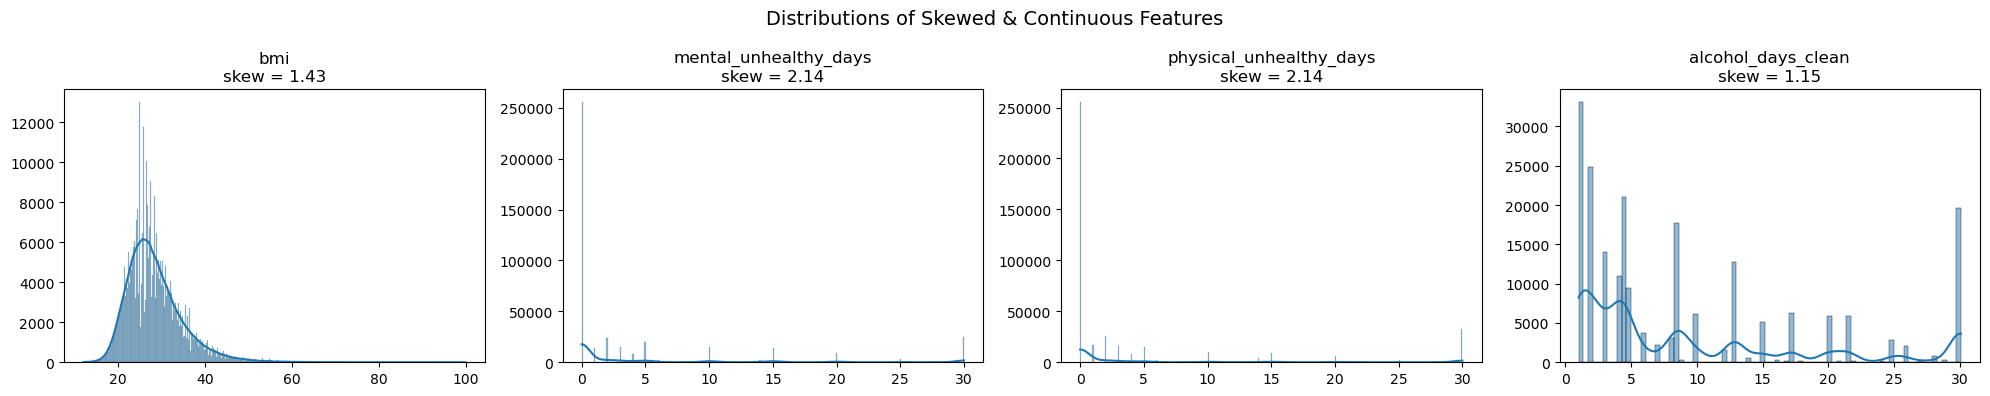

2025-05-04 16:03:10,319 INFO     brfss — {"timestamp": "2025-05-04T20:03:10.319353", "phase": "Phase2", "action": "Applied log1p to skewed features", "log1p_cols": ["bmi_log", "mental_unhealthy_days_log", "physical_unhealthy_days_log", "alcohol_days_clean_log"]}


In [195]:
from scipy.stats import skew

def transform_skewed_features(df, cols, log_event=None):
    from scipy.stats import skew
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    skew_report = []
    log_cols = []

    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(5 * len(cols), 4))

    for i, col in enumerate(cols):
        valid = df[col].dropna()
        sk = skew(valid) if len(valid) >= 3 else float('nan')
        skew_report.append((col, sk))

        # Apply log1p if abs(skew) > 1
        if abs(sk) > 1:
            new_col = f"{col}_log"
            df[new_col] = np.log1p(df[col].clip(lower=0))  # clipping negatives
            log_cols.append(new_col)

        sns.histplot(valid, kde=True, ax=axes[i])
        axes[i].set_title(f"{col}\nskew = {sk:.2f}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    plt.suptitle("Distributions of Skewed & Continuous Features", fontsize=14)
    plt.tight_layout()
    plt.show()

    if log_event:
        log_event(
            phase="Phase2",
            action="Applied log1p to skewed features",
            summary_dict={"log1p_cols": log_cols}
        )

    return df, skew_report, log_cols


numerical_cols = ['bmi', 'mental_unhealthy_days', 'physical_unhealthy_days', 'alcohol_days_clean']
df, skew_report, log_transform_cols = transform_skewed_features(df, numerical_cols, log_event=log_event)

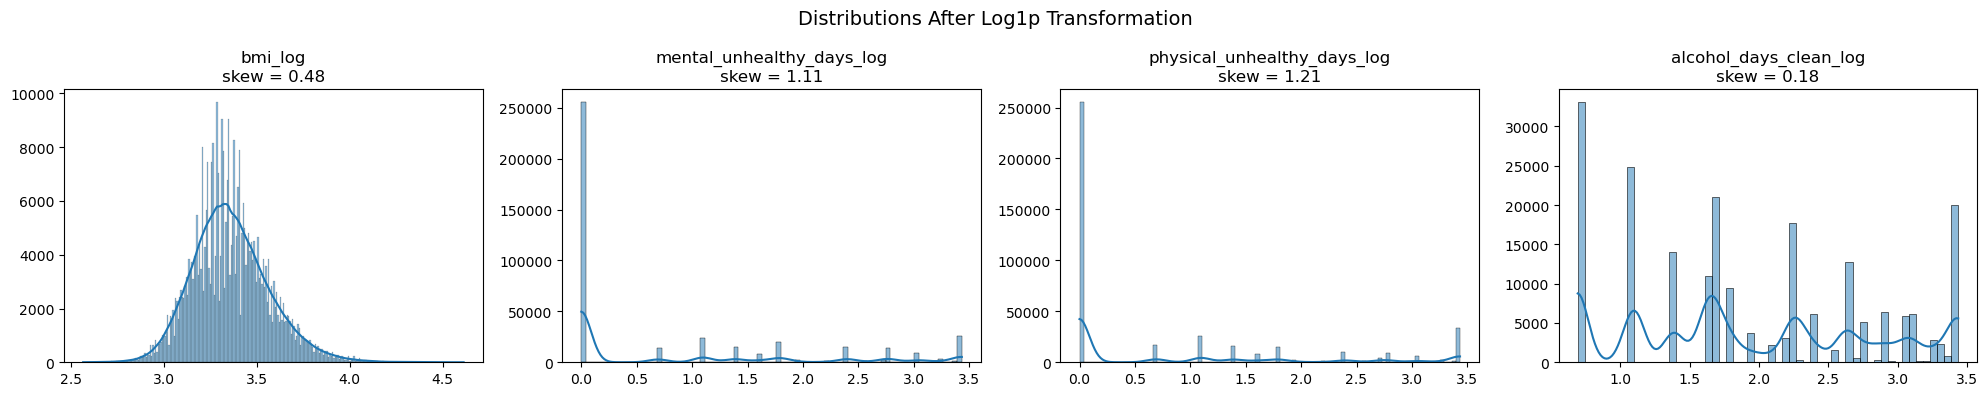

In [197]:
# log-transformed feature distributions
log_cols = log_transform_cols 
fig, axes = plt.subplots(nrows=1, ncols=len(log_cols), figsize=(5 * len(log_cols), 4))

for i, col in enumerate(log_cols):
    valid = df[col].dropna()
    sk = skew(valid)
    sns.histplot(valid, kde=True, ax=axes[i])
    axes[i].set_title(f"{col}\nskew = {sk:.2f}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.suptitle("Distributions After Log1p Transformation", fontsize=14)
plt.tight_layout()
plt.show()

# Binning

In [199]:
days_bins = [-1, 0, 7, 14, 21, 30]
days_labels = ["0 days", "1–7 days", "8–14 days", "15–21 days", "22–30 days"]
days_labels = [label.replace("–", "-") for label in days_labels]  # Normalize dash
days_cat = pd.api.types.CategoricalDtype(categories=days_labels, ordered=True)

bmi_bins = [0, 18.5, 25, 30, 35, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
bmi_cat = pd.api.types.CategoricalDtype(categories=bmi_labels, ordered=True)

# Binning loop for health days
for col in ['mental_unhealthy_days', 'physical_unhealthy_days']:
    valid_col = df[col].dropna()
    bin_col = f"{col}_bin"
    df[bin_col] = pd.cut(df[col], bins=days_bins, labels=days_labels, right=True)
    df[bin_col] = df[bin_col].astype(days_cat)

# Binning for BMI
df['bmi_bin'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels, right=True)
df['bmi_bin'] = df['bmi_bin'].astype(bmi_cat)

# Save binned feature names
binned_features = ['mental_unhealthy_days_bin', 'physical_unhealthy_days_bin', 'bmi_bin']

# Log bin counts
log_event(
    phase="Phase2",
    action="Binned mental/physical health days and BMI",
    summary_dict={
        "mental_bin_counts": df['mental_unhealthy_days_bin'].value_counts().to_dict(),
        "physical_bin_counts": df['physical_unhealthy_days_bin'].value_counts().to_dict(),
        "bmi_bin_counts": df['bmi_bin'].value_counts().to_dict()
    }
)

# Preview
df[['mental_unhealthy_days', 'mental_unhealthy_days_bin',
    'physical_unhealthy_days', 'physical_unhealthy_days_bin',
    'bmi', 'bmi_bin']].head(5)

2025-05-04 16:03:15,805 INFO     brfss — {"timestamp": "2025-05-04T20:03:15.805256", "phase": "Phase2", "action": "Binned mental/physical health days and BMI", "mental_bin_counts": {"0 days": 255624, "1-7 days": 83154, "22-30 days": 30391, "15-21 days": 24452, "8-14 days": 21298}, "physical_bin_counts": {"0 days": 255496, "1-7 days": 84651, "22-30 days": 37122, "8-14 days": 17747, "15-21 days": 16209}, "bmi_bin_counts": {"Overweight": 138852, "Normal": 116411, "Obese": 75636, "Extremely Obese": 53138, "Underweight": 6714}}


,mental_unhealthy_days,mental_unhealthy_days_bin,physical_unhealthy_days,physical_unhealthy_days_bin,bmi,bmi_bin
0,0.0,0 days,0.0,0 days,30.469999,Obese
1,0.0,0 days,0.0,0 days,28.559999,Overweight
2,2.0,1-7 days,6.0,1-7 days,22.309999,Normal
3,0.0,0 days,2.0,1-7 days,27.440001,Overweight
4,0.0,0 days,0.0,0 days,25.850000,Overweight


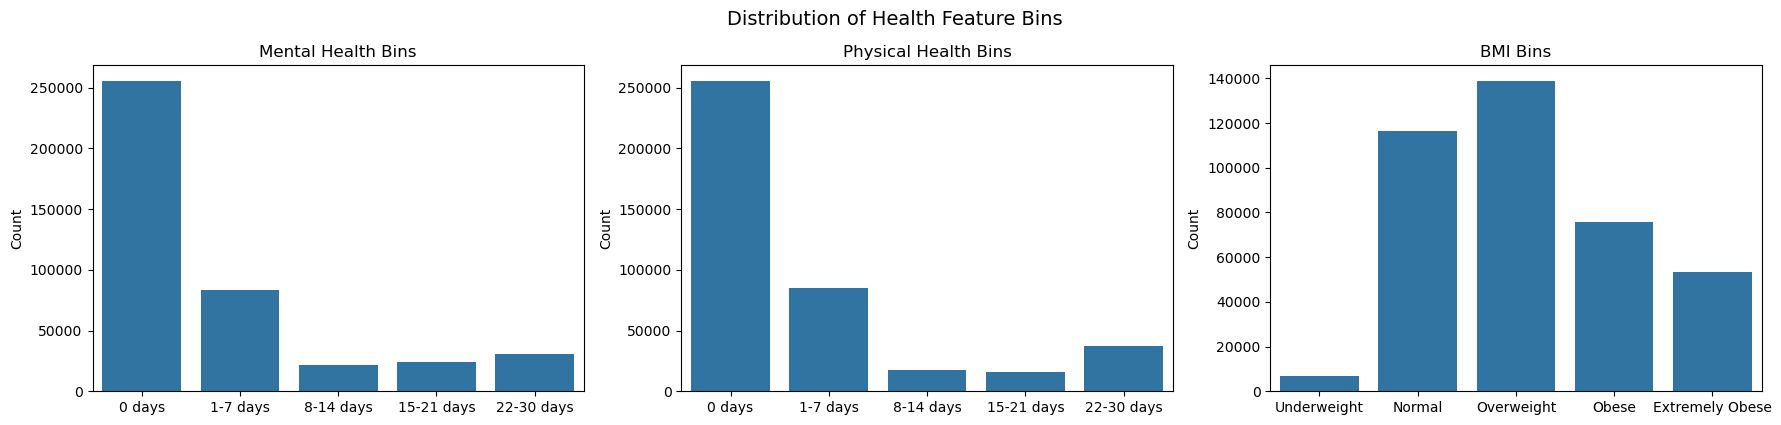

In [201]:
days_labels = ["0 days", "1-7 days", "8-14 days", "15-21 days", "22-30 days"]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.countplot(
    data=df,
    x='mental_unhealthy_days_bin',
    order=days_labels,
    ax=axes[0]
)
axes[0].set_title("Mental Health Bins")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("")

# Physical health
sns.countplot(
    data=df,
    x='physical_unhealthy_days_bin',
    order=days_labels,
    ax=axes[1]
)
axes[1].set_title("Physical Health Bins")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("")

# BMI
sns.countplot(
    data=df,
    x='bmi_bin',
    order=bmi_labels,
    ax=axes[2]
)
axes[2].set_title("BMI Bins")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")

plt.tight_layout()
plt.suptitle("Distribution of Health Feature Bins", fontsize=14, y=1.05)
plt.show()

In [203]:
from sklearn.preprocessing import StandardScaler

# List of columns to standardize (excluding weights)
numeric_to_scale = ['bmi'] + [col for col in df.columns if col.endswith('_log')]

scaler = StandardScaler()
df_std = df.copy()
valid_rows = df_std[numeric_to_scale].dropna()
df_std.loc[valid_rows.index, [f"{col}_z" for col in numeric_to_scale]] = (
    scaler.fit_transform(valid_rows)
)

z_summary = {
    f"{col}_z": {
        "min": float(round(df_std[f"{col}_z"].min(), 2)),
        "max": float(round(df_std[f"{col}_z"].max(), 2)),
        "mean": float(round(df_std[f"{col}_z"].mean(), 2)),
        "missing": int(df_std[f"{col}_z"].isna().sum())
    }
    for col in numeric_to_scale
}


log_event(
    phase="Phase2",
    action="Standardized numeric vars",
    summary_dict=z_summary
)

df_std[[f"{col}_z" for col in numeric_to_scale]].describe()

2025-05-04 16:03:22,544 INFO     brfss — {"timestamp": "2025-05-04T20:03:22.544612", "phase": "Phase2", "action": "Standardized numeric vars", "bmi_z": {"min": -2.67, "max": 11.88, "mean": -0.0, "missing": 241143}, "bmi_log_z": {"min": -4.04, "max": 6.49, "mean": -0.0, "missing": 241143}, "mental_unhealthy_days_log_z": {"min": -0.72, "max": 2.3, "mean": 0.0, "missing": 241143}, "physical_unhealthy_days_log_z": {"min": -0.63, "max": 2.61, "mean": -0.0, "missing": 241143}, "alcohol_days_clean_log_z": {"min": -1.43, "max": 1.65, "mean": 0.0, "missing": 241143}}


,bmi_z,bmi_log_z,mental_unhealthy_days_log_z,physical_unhealthy_days_log_z,alcohol_days_clean_log_z
count,1.896120e+05,1.896120e+05,1.896120e+05,1.896120e+05,1.896120e+05
mean,-2.434279e-16,-8.980152e-16,1.229131e-17,-4.316948e-17,4.131080e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.666820e+00,-4.041454e+00,-7.157440e-01,-6.275083e-01,-1.427708e+00
25%,-6.760974e-01,-6.767503e-01,-7.157440e-01,-6.275083e-01,-9.730307e-01
50%,-1.506528e-01,-6.286161e-02,-7.157440e-01,-6.275083e-01,-1.957543e-01
75%,4.808751e-01,5.895315e-01,6.954676e-01,4.075065e-01,7.463439e-01
max,1.188153e+01,6.494290e+00,2.295296e+00,2.607689e+00,1.649407e+00


In [205]:
df_std.head()

,age_group,sex,education,income,marital_status,race_ethnicity,smoked_100_cigs,current_smoker_flag,recent_exercise,meets_activity_guidelines,...,alcohol_days_clean,alcohol_days_clean_log,mental_unhealthy_days_bin,physical_unhealthy_days_bin,bmi_bin,bmi_z,bmi_log_z,mental_unhealthy_days_log_z,physical_unhealthy_days_log_z,alcohol_days_clean_log_z
0,13.0,2.0,5.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,0 days,0 days,Obese,NaN,NaN,NaN,NaN,NaN
1,13.0,2.0,5.0,NaN,2.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,0 days,0 days,Overweight,NaN,NaN,NaN,NaN,NaN
2,13.0,2.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,1-7 days,1-7 days,Normal,NaN,NaN,NaN,NaN,NaN
3,12.0,2.0,5.0,NaN,1.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,0 days,1-7 days,Overweight,NaN,NaN,NaN,NaN,NaN
4,12.0,2.0,5.0,NaN,3.0,1.0,0.0,1.0,1.0,1.0,...,2.0,1.098612,0 days,0 days,Overweight,-0.374423,-0.315406,-0.715744,-0.627508,-0.973031


# Mappings

In [208]:
# --- SHAP-Friendly Category Mapping ---
sex_map = {1: 'Male', 2: 'Female'}
marital_map = {
    1: 'Married', 2: 'Divorced', 3: 'Widowed', 4: 'Separated',
    5: 'Never married', 6: 'Unmarried couple', 9: np.nan
}
race_map = {1: 'White', 2: 'Black', 3: 'Other', 4: 'Multiracial', 5: 'Hispanic'}
genhlth_map = {
    1: 'Excellent', 2: 'Very good', 3: 'Good', 4: 'Fair', 5: 'Poor'
}

# Applying readable formats
df_std['general_health'] = df_std['general_health'].astype(object).replace(genhlth_map)
df_std['sex'] = df_std['sex'].astype(object).replace(sex_map)
df_std['marital_status'] = df_std['marital_status'].astype(object).replace(marital_map)
df_std['race_ethnicity'] = df_std['race_ethnicity'].astype(object).replace(race_map)

# Casting to category
for col in ['sex', 'marital_status', 'race_ethnicity']:
    df_std[col] = df_std[col].astype('category')

# Ordinal categoricals (no mapping)
for col in ['age_group', 'education', 'income']:
    df_std[col] = df_std[col].astype('category')

# --- Categorical Bins (with proper labels!) ---
binned_cols = ['mental_unhealthy_days_bin', 'physical_unhealthy_days_bin', 'bmi_bin']
bin_orders = {
    'mental_unhealthy_days_bin': ["0 days", "1-7 days", "8-14 days", "15-21 days", "22-30 days"],
    'physical_unhealthy_days_bin': ["0 days", "1-7 days", "8-14 days", "15-21 days", "22-30 days"],
    'bmi_bin': ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
}

# Apply correct categories and generate _code
for col in binned_cols:
    if col in df_std.columns:
        cat_type = pd.api.types.CategoricalDtype(categories=bin_orders[col], ordered=True)
        df_std[col] = df_std[col].astype(cat_type)
        df_std[f"{col}_code"] = df_std[col].cat.codes.replace(-1, np.nan)

# Log transformation
log_event(
    phase="Phase2",
    action="Mapped SHAP-readable categories + binned encodings",
    summary_dict={
        "mapped_categoricals": ['sex', 'marital_status', 'race_ethnicity', 'general_health'],
        "bin_code_features": [f"{col}_code" for col in binned_cols]
    }
)


2025-05-04 16:03:40,117 INFO     brfss — {"timestamp": "2025-05-04T20:03:40.117306", "phase": "Phase2", "action": "Mapped SHAP-readable categories + binned encodings", "mapped_categoricals": ["sex", "marital_status", "race_ethnicity", "general_health"], "bin_code_features": ["mental_unhealthy_days_bin_code", "physical_unhealthy_days_bin_code", "bmi_bin_code"]}


In [210]:
df_std.head()

,age_group,sex,education,income,marital_status,race_ethnicity,smoked_100_cigs,current_smoker_flag,recent_exercise,meets_activity_guidelines,...,physical_unhealthy_days_bin,bmi_bin,bmi_z,bmi_log_z,mental_unhealthy_days_log_z,physical_unhealthy_days_log_z,alcohol_days_clean_log_z,mental_unhealthy_days_bin_code,physical_unhealthy_days_bin_code,bmi_bin_code
0,13.0,Female,5.0,NaN,Married,White,0.0,1.0,0.0,0.0,...,0 days,Obese,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0
1,13.0,Female,5.0,NaN,Divorced,White,0.0,1.0,1.0,1.0,...,0 days,Overweight,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0
2,13.0,Female,4.0,2.0,Widowed,Black,1.0,1.0,1.0,1.0,...,1-7 days,Normal,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,12.0,Female,5.0,NaN,Married,White,0.0,1.0,1.0,1.0,...,1-7 days,Overweight,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2.0
4,12.0,Female,5.0,NaN,Widowed,White,0.0,1.0,1.0,1.0,...,0 days,Overweight,-0.374423,-0.315406,-0.715744,-0.627508,-0.973031,0.0,0.0,2.0


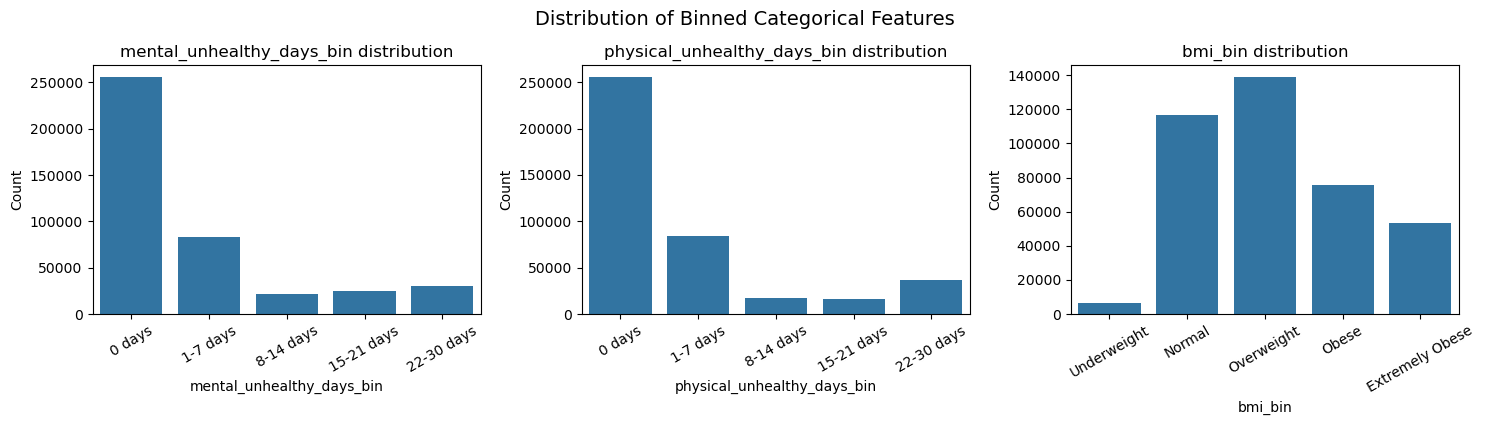

In [212]:
# Optional: Distribution Check
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(binned_cols):
    sns.countplot(data=df_std, x=col, order=df_std[col].cat.categories, ax=axes[i])
    axes[i].set_title(f"{col} distribution")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.suptitle("Distribution of Binned Categorical Features", fontsize=14, y=1.05)
plt.show()

In [249]:
import sys
sys.path.append('../src') 
from brfss_risk.utils.data_prep import generate_missing_report, add_missing_indicators

missing_report = generate_missing_report(df_std, threshold=0.005, log=True)
display(missing_report)

2025-05-04 21:43:12,978 INFO     brfss — {"timestamp": "2025-05-05T01:43:12.978776", "phase": "PhaseX", "action": "Missing Report", "top_missing_pct": {"taking_bp_meds": 0.5952, "alcohol_days_clean_log_z": 0.5598, "physical_unhealthy_days_log_z": 0.5598, "mental_unhealthy_days_log_z": 0.5598, "bmi_log_z": 0.5598, "bmi_z": 0.5598, "bmi_bin_code": 0.0929, "bmi_bin": 0.0929, "heavy_drinker": 0.0752, "chol_check_recent": 0.0604, "current_smoker_flag": 0.0527, "smoked_100_cigs": 0.0516, "physical_unhealthy_days_bin_code": 0.0453, "physical_unhealthy_days_bin": 0.0453, "has_health_insurance": 0.0425, "difficulty_walking": 0.0408, "mental_unhealthy_days_bin_code": 0.0368, "mental_unhealthy_days_bin": 0.0368, "race_ethnicity": 0.0217, "last_checkup": 0.0131, "marital_status": 0.0096, "has_primary_doctor": 0.0095, "skin_cancer": 0.0061, "prev_chd_or_mi": 0.0056, "ever_depression_dx": 0.0053, "education": 0.0051}}


,feature,pct_missing
18,taking_bp_meds,0.595248
37,alcohol_days_clean_log_z,0.559815
36,physical_unhealthy_days_log_z,0.559815
35,mental_unhealthy_days_log_z,0.559815
34,bmi_log_z,0.559815
33,bmi_z,0.559815
40,bmi_bin_code,0.092869
32,bmi_bin,0.092869
10,heavy_drinker,0.075154
21,chol_check_recent,0.060413


In [247]:
# Features to flag with missing indicators
flag_cols = [
    'bmi', 'bmi_log', 'alcohol_days_clean', 'alcohol_days_clean_log',
    'mental_unhealthy_days_log', 'physical_unhealthy_days_log',
    'income', 'high_cholesterol'
]

df_std = add_missing_indicators(df_std, cols=flag_cols)

# Log it
log_event(
    phase="Phase2",
    action="Added missing flags",
    summary_dict={"flagged_missing_features": flag_cols}
)

2025-05-04 21:43:08,347 INFO     brfss — {"timestamp": "2025-05-05T01:43:08.347133", "phase": "Phase2", "action": "Added missing flags", "flagged_missing_features": ["bmi", "bmi_log", "alcohol_days_clean", "alcohol_days_clean_log", "mental_unhealthy_days_log", "physical_unhealthy_days_log", "income", "high_cholesterol"]}


In [241]:
# Median for skewed continuous features
for col in ['bmi', 'bmi_log', 'alcohol_days_clean_log',
            'mental_unhealthy_days_log', 'physical_unhealthy_days_log']:
    if col in df_std.columns:
        df_std[col] = df_std[col].fillna(df_std[col].median())

# Mode for categorical/ordinal features
for col in ['income', 'high_cholesterol']:
    if col in df_std.columns:
        df_std[col] = df_std[col].fillna(df_std[col].mode()[0])

log_event(
    phase="Phase2",
    action="Imputed missing values",
    summary_dict={"median_imputed": ['bmi', 'bmi_log', 'alcohol_days_clean_log',
                                     'mental_unhealthy_days_log', 'physical_unhealthy_days_log'],
                  "mode_imputed": ['income', 'high_cholesterol']}
)

2025-05-04 21:42:30,561 INFO     brfss — {"timestamp": "2025-05-05T01:42:30.561880", "phase": "Phase2", "action": "Imputed missing values", "median_imputed": ["bmi", "bmi_log", "alcohol_days_clean_log", "mental_unhealthy_days_log", "physical_unhealthy_days_log"], "mode_imputed": ["income", "high_cholesterol"]}


In [235]:
# import os

# # Create the directory if it doesn't exist
# os.makedirs("data", exist_ok=True)
# print(os.getcwd())

# # Now safely save the preview
# df_std.head(200).to_csv("data/data_phase2_std_preview.csv", index=False)

/Users/rev/IUB/Projects/HeartAttackRiskPrediction/notebooks


In [243]:
# Drop original raw features that are now transformed and encoded
drop_cols = [
    'bmi_raw', 'alcohol_days', 'mental_unhealthy_days', 'physical_unhealthy_days',
    'alcohol_days_clean', 'alcohol_days_clean_log',
    'bmi_log', 'mental_unhealthy_days_log', 'physical_unhealthy_days_log'
]

df_std.drop(columns=[col for col in drop_cols if col in df_std.columns], inplace=True)

log_event(
    phase="Phase2",
    action="Dropped raw/intermediate log columns",
    summary_dict={"dropped_columns": drop_cols}
)

2025-05-04 21:42:57,204 INFO     brfss — {"timestamp": "2025-05-05T01:42:57.204172", "phase": "Phase2", "action": "Dropped raw/intermediate log columns", "dropped_columns": ["bmi_raw", "alcohol_days", "mental_unhealthy_days", "physical_unhealthy_days", "alcohol_days_clean", "alcohol_days_clean_log", "bmi_log", "mental_unhealthy_days_log", "physical_unhealthy_days_log"]}


In [280]:
import datetime
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

# Convert categorical columns with string labels to string dtype (for Arrow compatibility)
for col in df_std.select_dtypes(include='category').columns:
    if df_std[col].cat.categories.dtype == object:
        df_std[col] = df_std[col].astype(str)
project_root = Path(os.getcwd()).parent
SNAPSHOT_DIR = project_root / "data" / "derived"
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

# Create timestamped + latest path
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M")
ts_path     = os.path.join(SNAPSHOT_DIR, f"phase2_std_features_{ts}.parquet")
latest_path = os.path.join(SNAPSHOT_DIR, f"phase2_std_features_latest.parquet")

df_std.to_parquet(ts_path, index=False)
df_std.to_parquet(latest_path, index=False)

log_event(
    phase="Phase2",
    action="Saved standardized + transformed data",
    summary_dict={"timestamped_path": ts_path, "latest_path": latest_path}
)

print("Phase 2 snapshot saved to:")
print("  ", ts_path)
print("  ", latest_path)

2025-05-04 22:11:23,680 INFO     brfss — {"timestamp": "2025-05-05T02:11:23.680056", "phase": "Phase2", "action": "Saved standardized + transformed data", "timestamped_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase2_std_features_20250504_2211.parquet", "latest_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase2_std_features_latest.parquet"}
Phase 2 snapshot saved to:
   /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase2_std_features_20250504_2211.parquet
   /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase2_std_features_latest.parquet


In [278]:
project_root = Path(os.getcwd()).parent
project_root

PosixPath('/Users/rev/IUB/Projects/HeartAttackRiskPrediction')

# ---------------------------------------------
# Phase 3: Feature Insights & Variable Summary
# ---------------------------------------------

Heart Attack Class Distribution:
heart_attack
0    407304
1     23451
Name: count, dtype: int64

Proportions:
heart_attack
0    94.56%
1     5.44%
Name: count, dtype: object
2025-05-04 21:49:47,997 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 21:49:48,084 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


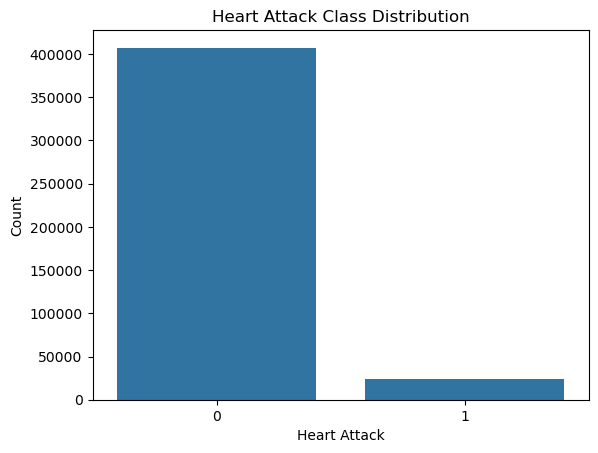

2025-05-04 21:49:48,168 INFO     brfss — {"timestamp": "2025-05-05T01:49:48.167994", "phase": "Phase3", "action": "Target variable analysis", "counts": {"0": 407304, "1": 23451}, "proportions": {"0": 0.9456, "1": 0.0544}}


In [259]:
# Check distribution of target
df_std['heart_attack'] = df_std['heart_attack'].replace({2.0: 0, 1.0: 1}).astype(int)
target_counts = df_std['heart_attack'].value_counts(dropna=False).sort_index()
target_pct = target_counts / target_counts.sum()

print("Heart Attack Class Distribution:")
print(target_counts)
print("\nProportions:")
print(target_pct.apply(lambda x: f"{x:.2%}"))

sns.countplot(x='heart_attack', data=df_std)
plt.title("Heart Attack Class Distribution")
plt.xlabel("Heart Attack")
plt.ylabel("Count")
plt.show()

log_event(
    phase="Phase3",
    action="Target variable analysis",
    summary_dict={
         "counts": {int(k): int(v) for k, v in target_counts.items()},
        "proportions": {int(k): float(v) for k, v in target_pct.round(4).items()}
    }
)

## Variable Profiling

In [154]:
# Categorical Profiling
categorical_summary = {}

for col in categorical_features:
    counts = (
        df_std
        .groupby([col, 'heart_attack'])
        .size()
        .unstack(fill_value=0)
    )
    counts['total'] = counts.sum(axis=1)
    counts['positive_rate'] = counts[1] / counts['total'].replace(0, np.nan)
    
    categorical_summary[col] = counts.sort_values('positive_rate', ascending=False)

    # Optionally display top categories with highest risk
    print(f"\n {col} (Top risk categories):")
    display(categorical_summary[col].head(3))
top_positive_rates = {col: df.nlargest(3, 'positive_rate') for col, df in categorical_summary.items()}
# Log summary counts (top 5)
log_event(
    phase="Phase3",
    action="Categorical variable profiling",
    summary_dict={
        "examined_vars": categorical_features[:5]  # top 5 for log brevity
    }
)

NameError: name 'categorical_features' is not defined

In [284]:
import datetime

project_root = Path(os.getcwd()).parent
output_path = project_root / "data" / "derived" / "categorical_summary_phase3.txt"

with open(output_path, "w") as f:
    f.write("Categorical Feature Profiling (Phase 3)\n")
    f.write(f"Generated on: {timestamp}\n")
    f.write("=" * 60 + "\n\n")

    for col in categorical_features:
        f.write(f"Feature: {col}\n")
        f.write("-" * 40 + "\n")

        counts = df_std[col].value_counts(dropna=False)
        props = df_std[col].value_counts(normalize=True, dropna=False).round(4) * 100
        summary = pd.concat([counts, props], axis=1)
        summary.columns = ["Count", "Percentage"]

        # Adding missing row
        if df_std[col].isna().sum() > 0:
            summary.loc["Missing"] = [
                df_std[col].isna().sum(),
                df_std[col].isna().mean() * 100
            ]

        f.write(summary.to_string())
        f.write("\n\n")

    # Positive rate summary (top 3 per feature)
    f.write("Top Categories by Heart Attack Positive Rate\n")
    f.write("=" * 60 + "\n\n")

    for col, df_cat in categorical_summary.items():
        f.write(f"{col} (Top 3 categories)\n")
        f.write("-" * 40 + "\n")
        top3 = df_cat[['positive_rate']].head(3).round(4)
        f.write(top3.to_string())
        f.write("\n\n")

print(f" Saved detailed categorical profiling to:\n  {output_path}")

 Saved detailed categorical profiling to:
  /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/categorical_summary_phase3.txt


/var/folders/g2/xx5xrh3d7rgfc8tp3b3cn9jr0000gn/T/ipykernel_62044/3618948360.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df_std.groupby(col)['heart_attack'].mean().reset_index()
/var/folders/g2/xx5xrh3d7rgfc8tp3b3cn9jr0000gn/T/ipykernel_62044/3618948360.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df_std.groupby(col)['heart_attack'].mean().reset_index()
/var/folders/g2/xx5xrh3d7rgfc8tp3b3cn9jr0000gn/T/ipykernel_62044/3618948360.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

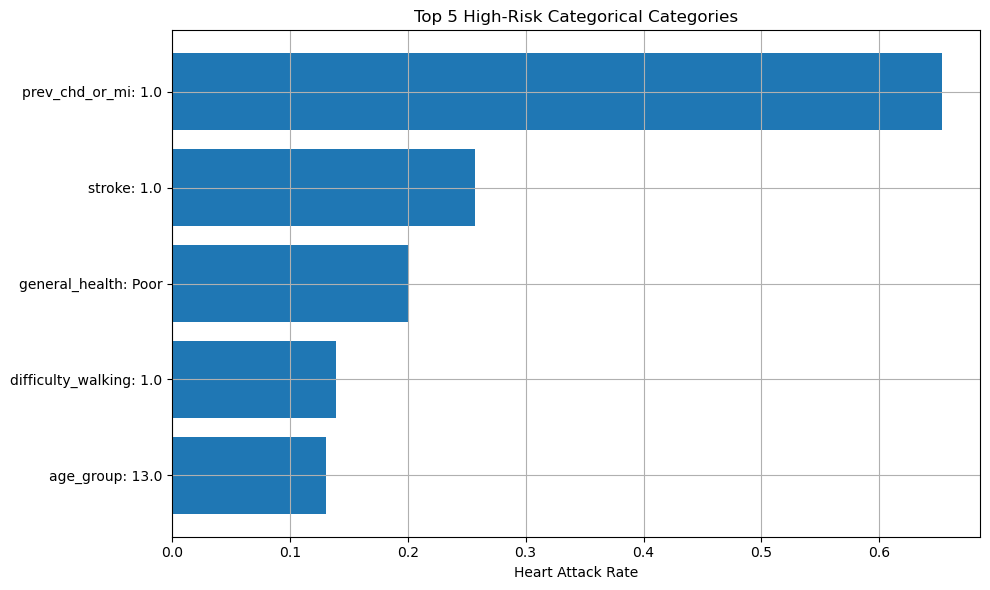

2025-05-04 22:17:02,180 INFO     brfss — {"timestamp": "2025-05-05T02:17:02.180884", "phase": "Phase3", "action": "Top 5 high-risk categorical categories", "prev_chd_or_mi: 1.0": 0.653, "stroke: 1.0": 0.257, "general_health: Poor": 0.201, "difficulty_walking: 1.0": 0.139, "age_group: 13.0": 0.131}


In [288]:
top_risk_plot_data = []

for col in categorical_features:
    temp = df_std.groupby(col)['heart_attack'].mean().reset_index()
    temp.columns = [col, 'positive_rate']
    temp = temp.sort_values('positive_rate', ascending=False)

    for _, row in temp.iterrows():
        top_risk_plot_data.append({
            "feature": col,
            "category": row[col],
            "positive_rate": row['positive_rate']
        })

risk_df = pd.DataFrame(top_risk_plot_data)
# Picking top category (with highest rate) for each feature
top_cats_per_feature = (
    risk_df.sort_values("positive_rate", ascending=False)
           .groupby("feature")
           .head(1)
           .sort_values("positive_rate", ascending=False)
           .head(5)
)

plt.figure(figsize=(10, 6))
plt.barh(top_cats_per_feature['feature'] + ": " + top_cats_per_feature['category'].astype(str), top_cats_per_feature['positive_rate'])
plt.xlabel("Heart Attack Rate")
plt.title("Top 5 High-Risk Categorical Categories")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
top_risk_log = {
    f"{row['feature']}: {row['category']}": round(row['positive_rate'], 3)
    for _, row in top_cats_per_feature.iterrows()
}

log_event(
    phase="Phase3",
    action="Top 5 high-risk categorical categories",
    summary_dict=top_risk_log
)

In [292]:
#Tracking High Risk Factors for later in Pipeline
N_TOP_RISK = 5
top_risk_features = top_cats_per_feature['feature'].unique().tolist()
project_root = Path(os.getcwd()).parent
output_path = project_root / "data" / "derived" / "phase3_top_risk_cat_features.json"
with open(output_path, "w") as f:
    json.dump(top_risk_features, f)

log_event(
    phase="Phase3",
    action="Flagged high-risk categorical features",
    summary_dict={"top_risk_features": top_risk_features}
)

print("Top high-risk features flagged:", top_risk_features)

2025-05-04 22:24:36,379 INFO     brfss — {"timestamp": "2025-05-05T02:24:36.379660", "phase": "Phase3", "action": "Flagged high-risk categorical features", "top_risk_features": ["prev_chd_or_mi", "stroke", "general_health", "difficulty_walking", "age_group"]}
Top high-risk features flagged: ['prev_chd_or_mi', 'stroke', 'general_health', 'difficulty_walking', 'age_group']


### Numerical Variable Risk Profiling

,feature,mean_heart_attack=0,mean_heart_attack=1,cohens_d
3,physical_unhealthy_days_log_z,-0.019,0.444,0.406
0,bmi_z,-0.005,0.121,0.127
2,mental_unhealthy_days_log_z,0.002,-0.057,-0.058
1,alcohol_days_clean_log_z,-0.001,0.024,0.025


/var/folders/g2/xx5xrh3d7rgfc8tp3b3cn9jr0000gn/T/ipykernel_62044/2389056511.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


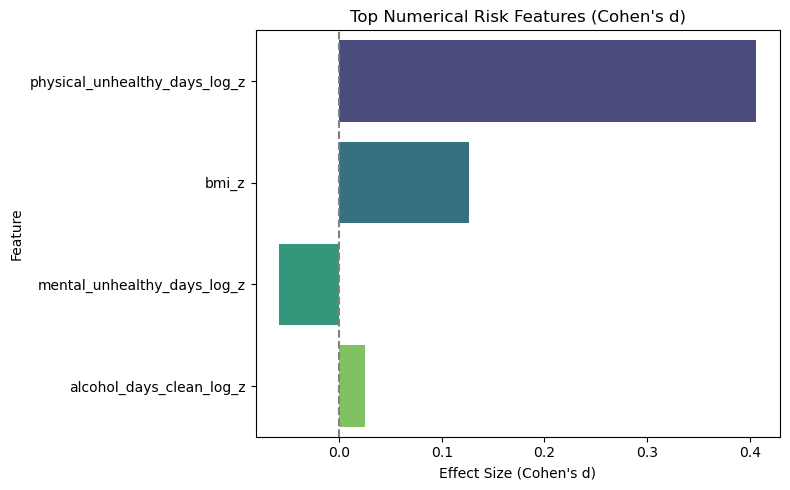

2025-05-04 22:46:06,142 INFO     brfss — {"timestamp": "2025-05-05T02:46:06.142499", "phase": "Phase3", "action": "Numerical variable effect sizes", "top_cohens_d": {"physical_unhealthy_days_log_z": 0.406, "bmi_z": 0.127, "mental_unhealthy_days_log_z": -0.058}}


<Figure size 640x480 with 0 Axes>

In [310]:
from scipy.stats import ttest_ind
import numpy as np

numerical_features = ['bmi_z', 'alcohol_days_clean_log_z', 'mental_unhealthy_days_log_z', 'physical_unhealthy_days_log_z']

risk_numeric_summary = []

for col in numerical_features:
    group_0 = df_std[df_std['heart_attack'] == 0][col].dropna()
    group_1 = df_std[df_std['heart_attack'] == 1][col].dropna()

    mean_0 = group_0.mean()
    mean_1 = group_1.mean()
    std_pooled = np.sqrt((group_0.std()**2 + group_1.std()**2) / 2)
    cohens_d = (mean_1 - mean_0) / std_pooled if std_pooled > 0 else np.nan

    risk_numeric_summary.append({
        'feature': col,
        'mean_heart_attack=0': round(mean_0, 3),
        'mean_heart_attack=1': round(mean_1, 3),
        'cohens_d': round(cohens_d, 3)
    })

risk_df = pd.DataFrame(risk_numeric_summary).sort_values('cohens_d', key=abs, ascending=False)
display(risk_df)

# Log top 3 risk numeric features
top_numeric_risks = risk_df.head(3).set_index('feature')['cohens_d'].to_dict()
plt.figure(figsize=(8, 5))
sns.barplot(
    data=risk_df.head(5), 
    x='cohens_d', 
    y='feature', 
    palette='viridis', 
    orient='h'
)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top Numerical Risk Features (Cohen's d)")
plt.xlabel("Effect Size (Cohen's d)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
log_event(
    phase="Phase3",
    action="Numerical variable effect sizes",
    summary_dict={"top_cohens_d": top_numeric_risks}
)
plt.savefig(project_root / "reports" / "top_numerical_risk_features_cohensd.png", dpi=300, bbox_inches='tight')

In [306]:
top_numeric_features = risk_df.sort_values('cohens_d', key=abs, ascending=False).head(3)['feature'].tolist()


output_path = project_root / "data" / "derived" / "top_numeric_risk_features.json"

with open(output_path, "w") as f:
    json.dump(top_numeric_features, f)

print(f"Top numeric risk features saved to:\n  {output_path}")

Top numeric risk features saved to:
  /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/top_numeric_risk_features.json


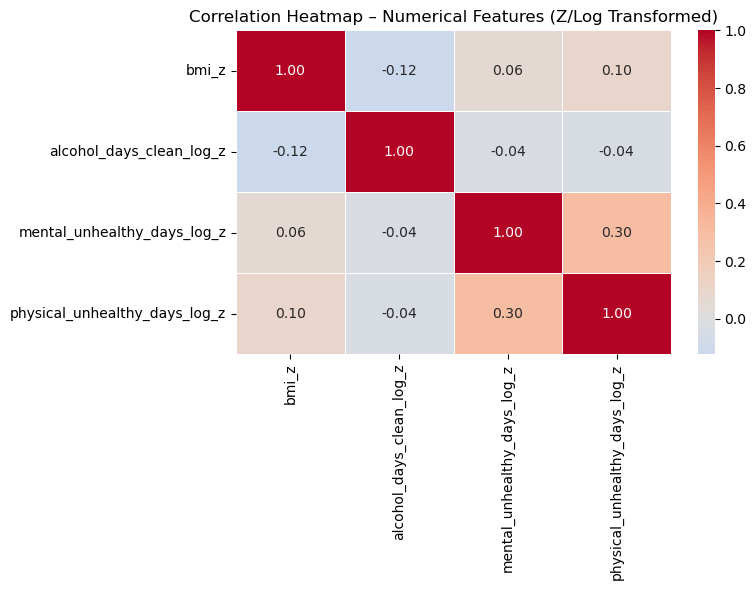

2025-05-04 22:51:15,748 INFO     brfss — {"timestamp": "2025-05-05T02:51:15.748475", "phase": "Phase3", "action": "Saved correlation heatmap and matrix", "correlation_file": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/numeric_feature_correlation_phase3.csv", "max_abs_corr": 0.301}
Correlation matrix saved to:
  /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/numeric_feature_correlation_phase3.csv


In [316]:
corr_matrix = df_std[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap – Numerical Features (Z/Log Transformed)")
plt.tight_layout()
plt.show()
output_path = project_root / "data" / "derived" / "numeric_feature_correlation_phase3.csv"
corr_matrix.to_csv(output_path)
log_event(
    phase="Phase3",
    action="Saved correlation heatmap and matrix",
    summary_dict={
        "correlation_file": str(output_path),
        "max_abs_corr": round(corr_matrix.where(~np.eye(len(corr_matrix), dtype=bool)).abs().max().max(), 3)
    }
)

print(f"Correlation matrix saved to:\n  {output_path}")

In [318]:
# Final feature list excluding target
final_features = [col for col in df_std.columns if col != 'heart_attack']

# Saving to JSON for reuse in modeling
with open(project_root / "data" / "derived" / "feature_list.json", "w") as f:
    json.dump(final_features, f)

log_event(
    phase="Phase3",
    action="Saved final feature list",
    summary_dict={"n_features": len(final_features)}
)

2025-05-04 22:54:49,689 INFO     brfss — {"timestamp": "2025-05-05T02:54:49.689414", "phase": "Phase3", "action": "Saved final feature list", "n_features": 48}


In [320]:
os.makedirs(SNAPSHOT_DIR, exist_ok=True)

SNAPSHOT_DIR = Path.cwd().parent / "data" / "derived"

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M")
ts_path     = os.path.join(SNAPSHOT_DIR, f"phase3_clean_final_{ts}.parquet")
latest_path = os.path.join(SNAPSHOT_DIR, f"phase3_clean_final_latest.parquet")

df_std.to_parquet(ts_path, index=False)
df_std.to_parquet(latest_path, index=False)
log_event(
    phase="Phase3",
    action="Saved cleaned + final modeling dataset",
    summary_dict={"timestamped_path": ts_path, "latest_path": latest_path}
)

print("Phase 3 snapshot saved to:")
print("  ", ts_path)
print("  ", latest_path)


2025-05-04 22:57:10,009 INFO     brfss — {"timestamp": "2025-05-05T02:57:10.009266", "phase": "Phase3", "action": "Saved cleaned + final modeling dataset", "timestamped_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase3_clean_final_20250504_2257.parquet", "latest_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase3_clean_final_latest.parquet"}
Phase 3 snapshot saved to:
   /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase3_clean_final_20250504_2257.parquet
   /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase3_clean_final_latest.parquet


# Phase 4 (Bivariate Analysis)

In [330]:
import pandas as pd

# Loading from Phase 3 snapshot
phase3_path = project_root/ "data/derived/phase3_clean_final_latest.parquet"
df_std = pd.read_parquet(phase3_path)

print("Loaded Phase 3 cleaned dataset.")
print("Shape:", df_std.shape)
df_std.head(3)

Loaded Phase 3 cleaned dataset.
Shape: (430755, 49)


,age_group,sex,education,income,marital_status,race_ethnicity,smoked_100_cigs,current_smoker_flag,recent_exercise,meets_activity_guidelines,...,physical_unhealthy_days_bin_code,bmi_bin_code,bmi_missing,bmi_log_missing,alcohol_days_clean_missing,alcohol_days_clean_log_missing,mental_unhealthy_days_log_missing,physical_unhealthy_days_log_missing,income_missing,high_cholesterol_missing
0,13.0,Female,5.0,8.0,Married,White,0.0,1.0,0.0,0.0,...,0.0,3.0,0,0,1,0,0,0,0,0
1,13.0,Female,5.0,8.0,Divorced,White,0.0,1.0,1.0,1.0,...,0.0,2.0,0,0,1,0,0,0,0,0
2,13.0,Female,4.0,2.0,Widowed,Black,1.0,1.0,1.0,1.0,...,1.0,1.0,0,0,1,0,0,0,0,0


##  Numerical Features vs Target

2025-05-04 23:17:28,312 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 23:17:28,437 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
T-test for bmi_z: t-stat=-10.98, p-val=0.0000
2025-05-04 23:17:29,151 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 23:17:29,270 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate d

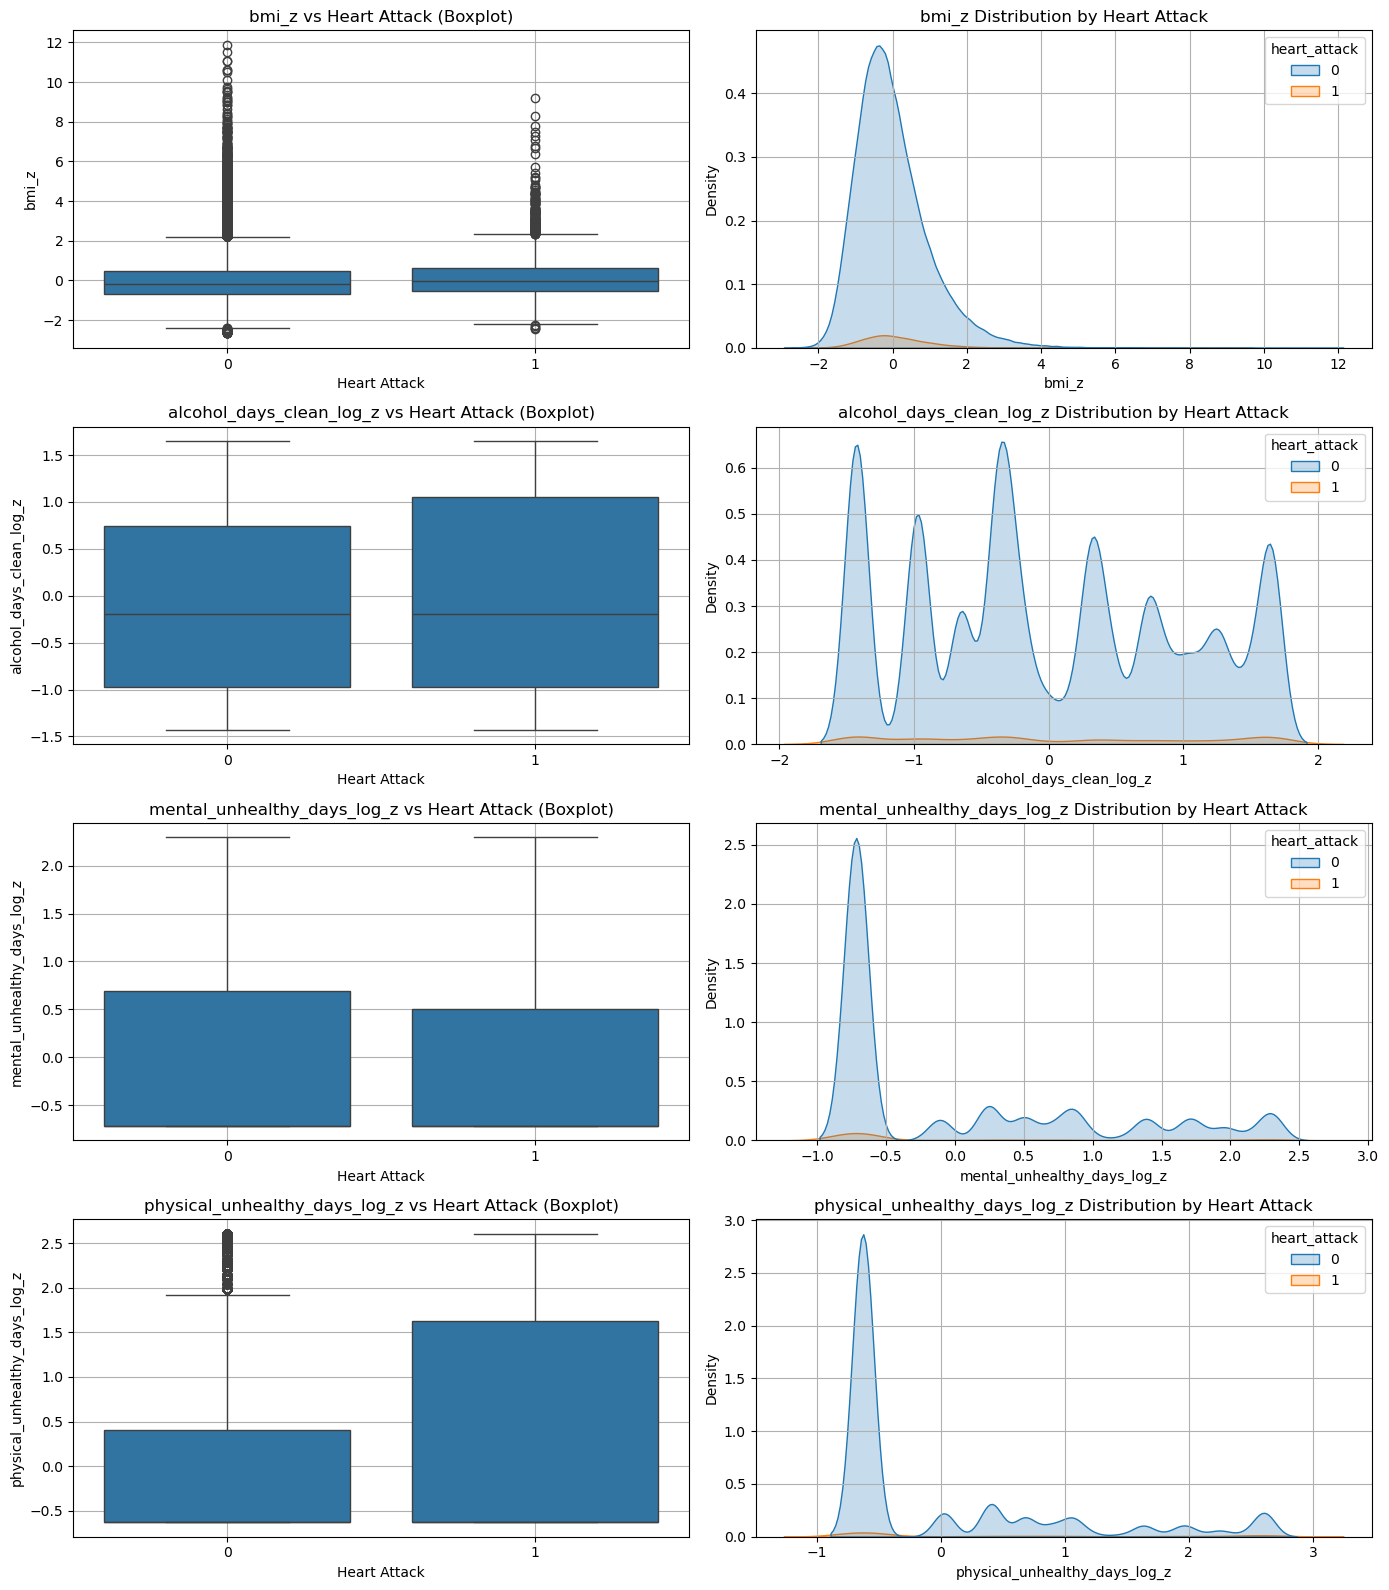

In [335]:
n_cols = 2
n_features = len(numerical_features)
n_rows = n_features

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))

for i, col in enumerate(numerical_features):
    # Boxplot
    sns.boxplot(data=df_std, x='heart_attack', y=col, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} vs Heart Attack (Boxplot)")
    axes[i, 0].set_xlabel("Heart Attack")
    axes[i, 0].set_ylabel(col)
    axes[i, 0].grid(True)

    # Distribution plot
    sns.kdeplot(data=df_std, x=col, hue='heart_attack', fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} Distribution by Heart Attack")
    axes[i, 1].grid(True)

    # T-test
    group0 = df_std[df_std['heart_attack'] == 0][col].dropna()
    group1 = df_std[df_std['heart_attack'] == 1][col].dropna()
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"T-test for {col}: t-stat={t_stat:.2f}, p-val={p_val:.4f}")

plt.tight_layout()
plt.show()

In [349]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import json

def log_numeric_ttests_with_effect_size(df, numerical_features, output_dir, log_event_func=None, top_n=3):
    results = []

    for col in numerical_features:
        group0 = df[df['heart_attack'] == 0][col].dropna()
        group1 = df[df['heart_attack'] == 1][col].dropna()

        # Stats
        t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
        mean0, mean1 = group0.mean(), group1.mean()
        std0, std1 = group0.std(), group1.std()

        # Cohen's d
        std_pooled = np.sqrt((std0**2 + std1**2) / 2)
        cohens_d = (mean1 - mean0) / std_pooled if std_pooled > 0 else np.nan

        results.append({
            "feature": col,
            "mean_0": round(mean0, 3),
            "mean_1": round(mean1, 3),
            "std_0": round(std0, 3),
            "std_1": round(std1, 3),
            "t_stat": round(t_stat, 4),
            "p_value": round(p_val, 6),
            "cohens_d": round(cohens_d, 4)
        })

    results_df = pd.DataFrame(results).sort_values("p_value")
    output_csv = output_dir / "phase4_numerical_stats.csv"
    results_df.to_csv(output_csv, index=False)

    # Saving top N by Cohen’s d
    top_effect = (
        results_df.assign(abs_d=lambda d: d['cohens_d'].abs())
        .sort_values("abs_d", ascending=False)
        .drop(columns="abs_d")
        .head(top_n)
        .set_index("feature")
        .to_dict(orient="index")
    )
    output_json = output_dir / "phase4_top_effect_numerics.json"
    with open(output_json, "w") as f:
        json.dump(top_effect, f, indent=2)

    # Optional: log
    if log_event_func:
        log_event_func(
            phase="Phase4",
            action="T-tests with effect size for numeric vars",
            summary_dict={
                "csv_path": str(output_csv),
                "json_path": str(output_json),
                "top_features": list(top_effect.keys())
            }
        )

    print(f" Full numeric stats saved to:\n  {output_csv}")
    print(f" Top {top_n} effect size features saved to:\n  {output_json}")
log_numeric_ttests_with_effect_size(df_std, numerical_features, output_dir=project_root / "reports", log_event_func=log_event)


2025-05-04 23:34:15,186 INFO     brfss — {"timestamp": "2025-05-05T03:34:15.186085", "phase": "Phase4", "action": "T-tests with effect size for numeric vars", "csv_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/reports/phase4_numerical_stats.csv", "json_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/reports/phase4_top_effect_numerics.json", "top_features": ["physical_unhealthy_days_log_z", "bmi_z", "mental_unhealthy_days_log_z"]}
 Full numeric stats saved to:
  /Users/rev/IUB/Projects/HeartAttackRiskPrediction/reports/phase4_numerical_stats.csv
 Top 3 effect size features saved to:
  /Users/rev/IUB/Projects/HeartAttackRiskPrediction/reports/phase4_top_effect_numerics.json


## Categorical Variables vs Heart Attack

2025-05-05 00:13:26,894 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-05 00:13:26,897 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-05 00:13:26,923 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-05 00:13:26,926 INFO     matplotlib.category — Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-05 00:13:26,

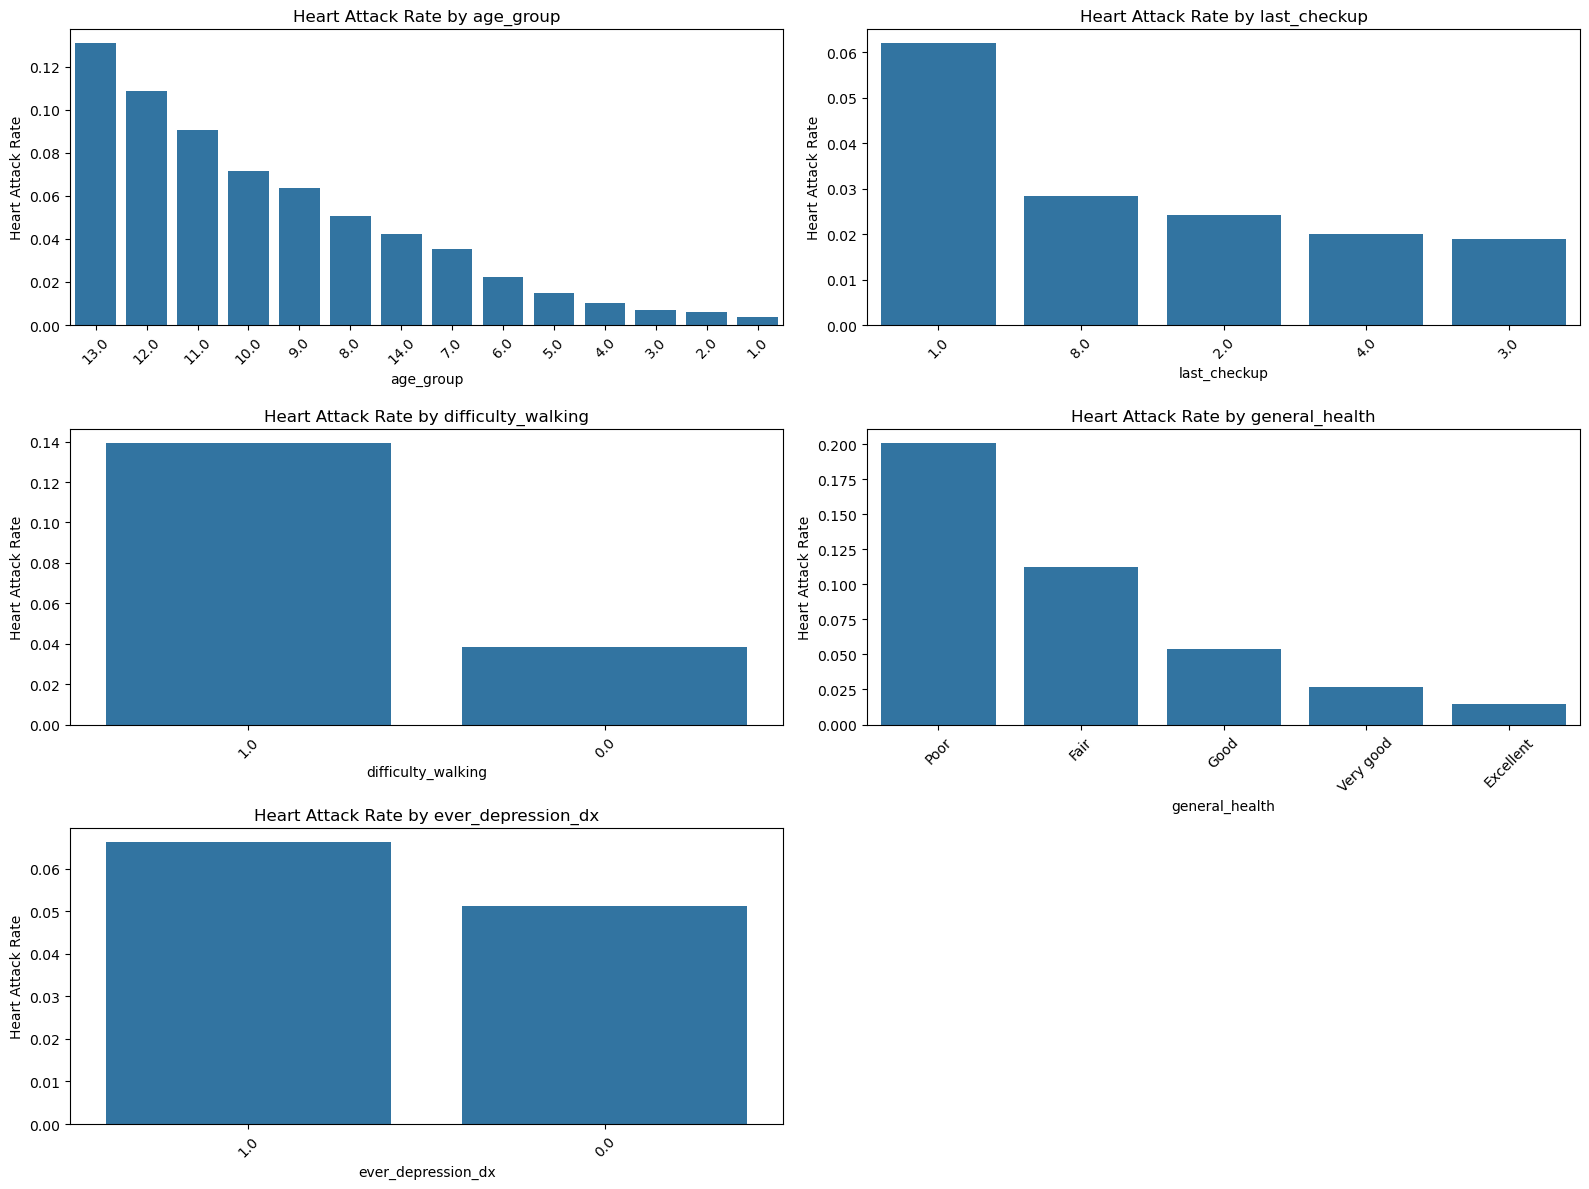

Chi-square test results and plot saved.


,feature,p_value
0,age_group,0.0
25,last_checkup,0.0
23,difficulty_walking,0.0
22,general_health,0.0
21,ever_depression_dx,0.0


In [372]:
from pathlib import Path
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

project_root = Path.cwd().parent
data_dir = project_root / "data" / "derived"
report_dir = project_root / "reports" / "phase4"
data_dir.mkdir(parents=True, exist_ok=True)
report_dir.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(data_dir / "phase3_clean_final_latest.parquet")

categorical_features = [
    'age_group', 'sex', 'education', 'income', 'marital_status', 'race_ethnicity',
    'smoked_100_cigs', 'current_smoker_flag', 'recent_exercise', 'meets_activity_guidelines',
    'heavy_drinker', 'has_health_insurance', 'diabetes', 'skin_cancer', 'other_cancer', 'asthma',
    'high_bp_flag', 'taking_bp_meds', 'stroke', 'high_cholesterol', 'chol_check_recent',
    'ever_depression_dx', 'general_health', 'difficulty_walking', 'cost_prevented_care',
    'last_checkup', 'has_primary_doctor', 'prev_chd_or_mi'
]

# Chi-square tests
chi2_results = []
for col in categorical_features:
    contingency = pd.crosstab(df[col], df['heart_attack'])
    if contingency.shape[0] > 1:
        chi2, p, _, _ = chi2_contingency(contingency)
        chi2_results.append({"feature": col, "p_value": round(p, 6)})

chi2_df = pd.DataFrame(chi2_results).sort_values("p_value")
chi2_df.to_csv(data_dir / "phase4_categorical_chi2_results.csv", index=False)

# Saving significant features
significant_cats = chi2_df[chi2_df["p_value"] < 0.05]["feature"].tolist()
with open(data_dir / "phase4_significant_categorical_features.json", "w") as f:
    json.dump(significant_cats, f)

# Ploting top 5 categorical variables by heart attack rate
top_5_cats = chi2_df.head(5)["feature"].tolist()
ncols = 2
nrows = math.ceil(len(top_5_cats) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(top_5_cats):
    rates = df.groupby(col)["heart_attack"].mean().sort_values(ascending=False)
    sns.barplot(x=rates.index.astype(str), y=rates.values, ax=axes[i])
    axes[i].set_title(f"Heart Attack Rate by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Heart Attack Rate")
    axes[i].tick_params(axis='x', rotation=45)


# Turn off unused axes
for j in range(len(top_5_cats), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(report_dir / "top5_heart_attack_rates_by_category.png")
plt.show()

print("Chi-square test results and plot saved.")
display(chi2_df.head())


In [386]:
with open(data_dir / "top_risk_features.json", "r") as f:
    phase3_top_cat_features = set(json.load(f))

chi2_df = pd.read_csv(data_dir / "phase4_categorical_chi2_results.csv")

phase4_significant_cats = set(chi2_df[chi2_df["p_value"] < 0.05]["feature"])

# Compare
overlap = phase3_top_cat_features & phase4_significant_cats
phase3_only = phase3_top_cat_features - phase4_significant_cats
phase4_only = phase4_significant_cats - phase3_top_cat_features
final_cat_features = sorted(overlap | phase4_only)
final_path = data_dir / "final_categorical_features.json"
with open(final_path, "w") as f:
    json.dump(final_cat_features, f)
print("Overlapping Features:", sorted(overlap))
print("Phase 3 (Univariate) Only:", sorted(phase3_only))
print("Phase 4 (Bivariate) Only:", sorted(phase4_only))

Overlapping Features: ['age_group', 'difficulty_walking', 'general_health', 'prev_chd_or_mi', 'stroke']
Phase 3 (Univariate) Only: []
Phase 4 (Bivariate) Only: ['asthma', 'chol_check_recent', 'cost_prevented_care', 'current_smoker_flag', 'diabetes', 'education', 'ever_depression_dx', 'has_health_insurance', 'has_primary_doctor', 'heavy_drinker', 'high_bp_flag', 'high_cholesterol', 'income', 'last_checkup', 'marital_status', 'meets_activity_guidelines', 'other_cancer', 'race_ethnicity', 'recent_exercise', 'sex', 'skin_cancer', 'smoked_100_cigs', 'taking_bp_meds']


In [414]:
from itertools import combinations
output_dir = project_root / "data" / "derived"
output_dir.mkdir(parents=True, exist_ok=True)

# Pairwise Chi-Square Between Categorical Features 
chi2_pairs = []
for col1, col2 in combinations(final_cat_features, 2):
    if col1 in df.columns and col2 in df.columns:
        try:
            contingency = pd.crosstab(df[col1], df[col2])
            if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                _, p, _, _ = chi2_contingency(contingency)
                chi2_pairs.append({"feature_1": col1, "feature_2": col2, "p_value": round(p, 5)})
        except Exception:
            continue

chi2_pair_df = pd.DataFrame(chi2_pairs)
chi2_pair_df.to_csv(output_dir / "phase4_categorical_feature_pairwise_pvals.csv", index=False)
print(" Saved: phase4_categorical_feature_pairwise_pvals.csv", chi2_pair_df.head(3))

# Category Size Summary
cat_size_summary = []
for col in final_cat_features:
    if col in df.columns:
        counts = df[col].value_counts(dropna=False)
        for cat_val, count in counts.items():
            cat_size_summary.append({
                "feature": col,
                "category": cat_val,
                "count": count
            })

cat_size_df = pd.DataFrame(cat_size_summary)
cat_size_df.to_csv(output_dir / "phase4_category_size_summary.csv", index=False)
print("Saved: phase4_category_size_summary.csv", cat_size_df.head(3))

# === Flag rare categories (e.g., < 1000) ===
rare_cats = cat_size_df[(cat_size_df['count'] < 1000) & (cat_size_df['category'].notna())]
rare_cats.to_csv(output_dir / "phase4_rare_category_flags.csv", index=False)
print(f" Flagged {len(rare_cats)} rare categories (<1000 instances)", rare_cats)


# from collections import Counter

# # Step 1: Redundant Pairs (Chi2 p < 0.01)
# redundant_pairs = chi2_pair_df[chi2_pair_df["p_value"] < 0.01].copy()

# # Count frequency of appearance across pairs
# flat_features = redundant_pairs[["feature_1", "feature_2"]].values.flatten()
# feature_freq = Counter(flat_features)

# redundant_pairs["feature_1_freq"] = redundant_pairs["feature_1"].map(feature_freq)
# redundant_pairs["feature_2_freq"] = redundant_pairs["feature_2"].map(feature_freq)

# # Step 2: Rare Category Summary (count < 1000)
# rare_cats = cat_size_df[(cat_size_df["count"] < 1000) & (cat_size_df["category"].notna())]
# rare_cat_summary = (
#     rare_cats.groupby("feature")
#     .agg(num_rare_categories=("category", "count"), min_count=("count", "min"))
#     .reset_index()
# )

# # Add rarity flags to both features in redundant pairs
# redundant_pairs = redundant_pairs.merge(rare_cat_summary[["feature", "num_rare_categories"]],
#                                         how="left", left_on="feature_1", right_on="feature")
# redundant_pairs.rename(columns={"num_rare_categories": "feature_1_rare_cats"}, inplace=True)
# redundant_pairs.drop(columns="feature", inplace=True)

# redundant_pairs = redundant_pairs.merge(rare_cat_summary[["feature", "num_rare_categories"]],
#                                         how="left", left_on="feature_2", right_on="feature")
# redundant_pairs.rename(columns={"num_rare_categories": "feature_2_rare_cats"}, inplace=True)
# redundant_pairs.drop(columns="feature", inplace=True)

# # Fill missing rare cat values with 0
# redundant_pairs["feature_1_rare_cats"] = redundant_pairs["feature_1_rare_cats"].fillna(0).astype(int)
# redundant_pairs["feature_2_rare_cats"] = redundant_pairs["feature_2_rare_cats"].fillna(0).astype(int)

# # Final combined table
# display(redundant_pairs.sort_values("p_value").head(10))

# # Optional: Save to CSV
# redundant_pairs.to_csv(data_dir / "phase4_categorical_redundancy_and_rarity.csv", index=False)

 Saved: phase4_categorical_feature_pairwise_pvals.csv    feature_1            feature_2  p_value
0  age_group               asthma      0.0
1  age_group    chol_check_recent      0.0
2  age_group  cost_prevented_care      0.0
Saved: phase4_category_size_summary.csv      feature category  count
0  age_group     10.0  45845
1  age_group     11.0  43267
2  age_group      9.0  41757
 Flagged 1 rare categories (<1000 instances)       feature category  count
42  education      1.0    670


In [420]:

numerical_z_cols = [col for col in df_std.columns if col.endswith('_z')]

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Computing effect sizes for standardized numerical features
effect_sizes = []
for col in numerical_z_cols:
    group0 = df_std[df_std['heart_attack'] == 0][col].dropna()
    group1 = df_std[df_std['heart_attack'] == 1][col].dropna()
    d = cohen_d(group1, group0)
    effect_sizes.append({"feature": col, "cohen_d": round(d, 3)})

effect_size_df = pd.DataFrame(effect_sizes)
effect_size_df['abs_d'] = effect_size_df['cohen_d'].abs()
effect_size_df = effect_size_df.sort_values(by='abs_d', ascending=False).drop(columns='abs_d')

log_event(
    phase="Phase4",
    action="Computed effect sizes for standardized numerical features",
    summary_dict={
        "effect_sizes": {
            row['feature']: row['cohen_d'] for _, row in effect_size_df.iterrows()
        }
    }
)

output_path = Path(project_root) / "reports" / "phase4_effect_sizes.csv"
effect_size_df.to_csv(output_path, index=False)

effect_size_df

2025-05-05 13:01:28,144 INFO     brfss — {"timestamp": "2025-05-05T17:01:28.144280", "phase": "Phase4", "action": "Computed effect sizes for standardized numerical features", "effect_sizes": {"physical_unhealthy_days_log_z": 0.465, "bmi_log_z": 0.14, "bmi_z": 0.126, "mental_unhealthy_days_log_z": -0.059, "alcohol_days_clean_log_z": 0.026}}


,feature,cohen_d
3,physical_unhealthy_days_log_z,0.465
1,bmi_log_z,0.140
0,bmi_z,0.126
2,mental_unhealthy_days_log_z,-0.059
4,alcohol_days_clean_log_z,0.026


### correlation matrix of standardized numerical features

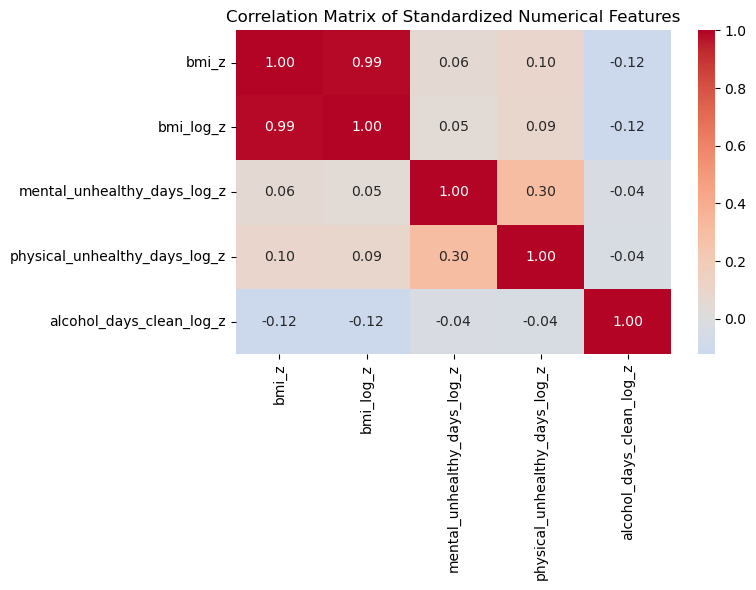

2025-05-05 13:10:17,654 INFO     brfss — {"timestamp": "2025-05-05T17:10:17.654555", "phase": "Phase4", "action": "Checked multicollinearity among standardized numerical features", "n_strong_corr_pairs": 0}


,feature_1,feature_2,correlation
0,bmi_z,bmi_log_z,0.986586


In [422]:
corr_matrix = df_std[numerical_z_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Standardized Numerical Features")
plt.tight_layout()
plt.show()

# Identify strongly correlated feature pairs (|corr| > 0.8)
strong_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
strong_corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['correlation'].abs() > 0.8]
log_event(
    phase="Phase4",
    action="Checked multicollinearity among standardized numerical features",
    summary_dict={"n_strong_corr_pairs": 0}
)

strong_corr_pairs

In [480]:

PVAL_THRESH   = 0.01       
RARE_COUNT    = 1000        
ALPHA_TARGET  = 0.05        
project_root = Path.cwd().parent
data_dir     = project_root / "data" / "derived"
report_dir   = project_root / "reports" / "phase4"
data_dir.mkdir(parents=True, exist_ok=True)
report_dir.mkdir(parents=True, exist_ok=True)

pairwise_df = pd.read_csv(data_dir / "phase4_categorical_feature_pairwise_pvals.csv")
cat_size_df = pd.read_csv(data_dir / "phase4_category_size_summary.csv")
chi2_df     = pd.read_csv(data_dir / "phase4_categorical_chi2_results.csv")
df_std      = pd.read_parquet(data_dir / "phase3_clean_final_latest.parquet")

#Redundancy
redundant_pairs = pairwise_df.loc[pairwise_df["p_value"] < PVAL_THRESH]
redundant_feats = set(redundant_pairs["feature_1"].tolist() +
                      redundant_pairs["feature_2"].tolist())
#Rarity
size_col   = next(c for c in cat_size_df.columns if c.lower() in {"count","n","freq"})
rare_feats = set(cat_size_df.loc[cat_size_df[size_col] < RARE_COUNT, "feature"])

#Non‑significance
non_sig_feats = set(chi2_df.loc[chi2_df["p_value"] > ALPHA_TARGET, "feature"])

#Final Pruning
drop_categorical_features = sorted(redundant_feats & (rare_feats | non_sig_feats))
print(f"Recommended categorical drops ({len(drop_categorical_features)}):")
print(drop_categorical_features)

Recommended categorical drops (2):
['diabetes', 'education']


In [467]:
# --- Manual override: Recode diabetes before dropping ---
# Create a binary flag from known diabetes-related categories
# diabetes_positive = [
#     "Yes",
#     "Yes (only during pregnancy)",
#     "Borderline",
#     "Pre-diabetes",
#     "Gestational diabetes",
# ]
# df_std["diabetes_flag"] = df_std["diabetes"].isin(diabetes_positive).astype(int)

# # Optional: check signal
# from scipy.stats import chi2_contingency
# ct = pd.crosstab(df_std["diabetes_flag"], df_std["heart_attack"])
# chi2, p, _, _ = chi2_contingency(ct)
# print(f"Chi-square p-value for diabetes_flag: {p:.4f}")

In [492]:
# cat_cols = [c for c in df_std if c not in keep_features]
# # df_std.head()
# cat_cols

['age_group',
 'sex',
 'education',
 'income',
 'marital_status',
 'race_ethnicity',
 'smoked_100_cigs',
 'current_smoker_flag',
 'recent_exercise',
 'meets_activity_guidelines',
 'heavy_drinker',
 'has_health_insurance',
 'prev_chd_or_mi',
 'diabetes',
 'skin_cancer',
 'other_cancer',
 'asthma',
 'high_bp_flag',
 'taking_bp_meds',
 'stroke',
 'high_cholesterol',
 'chol_check_recent',
 'ever_depression_dx',
 'general_health',
 'difficulty_walking',
 'cost_prevented_care',
 'last_checkup',
 'has_primary_doctor',
 'heart_attack',
 'bmi',
 'mental_unhealthy_days_bin',
 'physical_unhealthy_days_bin',
 'bmi_bin',
 'bmi_log_z',
 'mental_unhealthy_days_log_z',
 'alcohol_days_clean_log_z',
 'mental_unhealthy_days_bin_code',
 'physical_unhealthy_days_bin_code',
 'bmi_bin_code',
 'bmi_missing',
 'bmi_log_missing',
 'alcohol_days_clean_missing',
 'alcohol_days_clean_log_missing',
 'mental_unhealthy_days_log_missing',
 'physical_unhealthy_days_log_missing',
 'income_missing',
 'high_cholesterol_mi

In [494]:
# df_std[cat_cols].dtypes


age_group                              float64
sex                                     object
education                              float64
income                                 float64
marital_status                          object
race_ethnicity                          object
smoked_100_cigs                        float64
current_smoker_flag                    float64
recent_exercise                        float64
meets_activity_guidelines              float64
heavy_drinker                          float64
has_health_insurance                   float64
prev_chd_or_mi                         float64
diabetes                               float64
skin_cancer                            float64
other_cancer                           float64
asthma                                 float64
high_bp_flag                           float64
taking_bp_meds                         float64
stroke                                 float64
high_cholesterol                       float64
chol_check_re

In [482]:
df_pruned = df_std.drop(columns=drop_categorical_features, errors="ignore")
drop_json_path = data_dir / "phase4_pruned_categorical_features.json"
Path(drop_json_path).write_text(json.dumps(drop_categorical_features, indent=2))

ts_path     = data_dir / "phase4_cleaned_after_pruning.parquet"
latest_path = data_dir / "phase4_cleaned_after_pruning_latest.parquet"

df_pruned.to_parquet(ts_path, index=False)
df_pruned.to_parquet(latest_path, index=False)

print("\nPruned dataset saved.")
print("Snapshot:", ts_path)
print("Latest:  ", latest_path)
print("Shape:   ", df_pruned.shape)


✅ Pruned dataset saved.
Snapshot: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase4_cleaned_after_pruning.parquet
Latest:   /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/phase4_cleaned_after_pruning_latest.parquet
Shape:    (430755, 47)


In [446]:
report_dir = project_root / "reports" 
p_thresh = 0.05
d_thresh = 0.1

# --- Load metrics ---
num_stats_path = report_dir / "phase4_numerical_stats.csv"
df_stats = pd.read_csv(num_stats_path)

# --- Compute absolute d and filter ---
df_stats["abs_d"] = df_stats["cohens_d"].abs()
keep_df = df_stats[(df_stats["p_value"] < p_thresh) & (df_stats["abs_d"] >= d_thresh)]
drop_df = df_stats[~((df_stats["p_value"] < p_thresh) & (df_stats["abs_d"] >= d_thresh))]

keep_features = keep_df["feature"].tolist()
drop_features = drop_df["feature"].tolist()

# --- Save drop list (optional) ---
drop_json = data_dir / "phase4_weak_numerical_features.json"
with open(drop_json, "w") as f:
    json.dump(drop_features, f, indent=2)

print("Numerical feature selection complete.")
print("Keeping:", keep_features)
print("Dropping:", drop_features)

Numerical feature selection complete.
Keeping: ['bmi_z', 'physical_unhealthy_days_log_z']
Dropping: ['mental_unhealthy_days_log_z', 'alcohol_days_clean_log_z']


In [56]:
from datetime import datetime, timezone

project_root = Path.cwd().parent
data_dir     = project_root / "data" / "derived"
report_dir   = project_root / "reports"
drop_json    = data_dir / "phase4_weak_numerical_features.json"


ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M")
# --- Load pruned categorical dataset ---
df_pruned = pd.read_parquet(data_dir / "phase4_cleaned_after_pruning_latest.parquet")

# --- Load drop list for weak numericals ---
with open(drop_json, "r") as f:
    drop_numerical_features = json.load(f)

# --- Apply pruning ---
df_phase4_final = df_pruned.drop(columns=drop_numerical_features, errors="ignore")

# --- Save final dataset ---
ts_path     = data_dir / "phase4_pruned_all_final.parquet"
latest_path = data_dir / "phase4_pruned_all_latest.parquet"
full_csv    = data_dir / f"phase4_pruned_all_latest_{ts}.csv"
sample_csv  = data_dir / "phase4_pruned_all_latest_sample20.csv"
df_phase4_final.to_parquet(ts_path, index=False)
df_phase4_final.to_parquet(latest_path, index=False)
df_phase4_final.to_csv(full_csv, index=False)
df_phase4_final.sample(frac=0.20, random_state=42).to_csv(sample_csv, index=False)

# --- Save feature list (excluding target) ---
final_features = [col for col in df_phase4_final.columns if col != "heart_attack"]
with open(data_dir / "feature_list.json", "w") as f:
    json.dump(final_features, f, indent=2)

# --- Output summary ---
print("Phase 4 pruning complete and saved.")
print("Final shape:", df_phase4_final.shape)
print("Saved feature list →", data_dir / "feature_list.json")

Phase 4 pruning complete and saved.
Final shape: (430755, 45)
Saved feature list → /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/derived/feature_list.json


In [458]:
# import os, datetime
# import json
# from pathlib import Path

project_root   = Path.cwd().parent
SNAPSHOT_DIR   = project_root / "data" / "processed"
SNAPSHOT_DIR.mkdir(parents=True, exist_ok=True)

# Timestamped filenames
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M")
ts_path     = SNAPSHOT_DIR / f"phase4_df_std_final_{ts}.parquet"
latest_path = SNAPSHOT_DIR / "phase4_df_std_final_latest.parquet"
raw_cleaned = SNAPSHOT_DIR / "phase4_df_sel_clean_latest.parquet"
feat_path   = SNAPSHOT_DIR / "feature_list.json"

df_phase4_final.to_parquet(ts_path, index=False)
df_phase4_final.to_parquet(latest_path, index=False)
df_sel.to_parquet(raw_cleaned, index=False)

with open(feat_path, "w") as f:
    json.dump(final_features, f, indent=2)

log_event(
    phase="Phase4",
    action="Saved final standardized and raw cleaned datasets",
    summary_dict={
        "timestamped_path": str(ts_path),
        "latest_path": str(latest_path),
        "raw_cleaned_path": str(raw_cleaned),
        "feature_list_path": str(feat_path),
        "n_rows": len(df_std),
        "n_columns": df_std.shape[1]
    }
)

print("Phase 4 snapshot saved.")
print("Standardized:", ts_path)
print("Latest std: ", latest_path)
print("Cleaned raw:", raw_cleaned)
print("Feature list:", feat_path)


2025-05-06 00:08:21,985 INFO     brfss — {"timestamp": "2025-05-06T04:08:21.985565", "phase": "Phase4", "action": "Saved final standardized and raw cleaned datasets", "timestamped_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/processed/phase4_df_std_final_20250506_0008.parquet", "latest_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/processed/phase4_df_std_final_latest.parquet", "raw_cleaned_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/processed/phase4_df_sel_clean_latest.parquet", "feature_list_path": "/Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/processed/feature_list.json", "n_rows": 430755, "n_columns": 49}
Phase 4 snapshot saved.
Standardized: /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/processed/phase4_df_std_final_20250506_0008.parquet
Latest std:  /Users/rev/IUB/Projects/HeartAttackRiskPrediction/data/processed/phase4_df_std_final_latest.parquet
Cleaned raw: /Users/rev/IUB/Projects/HeartAttackRiskPrediction

In [58]:
import boto3, time
from boto3.s3.transfer import TransferConfig
from datetime import datetime, timezone
from pathlib import Path

bucket = "verikai-heart-risk-pipeline"

# If you already built full_csv earlier:
#   full_csv = data_dir / f"phase4_pruned_all_latest_{ts}.csv"
# …then you can extract the timestamp from its name:

ts = Path(full_csv).stem.split("_")[-1]        
s3_key = f"data/processed_data/phase4_pruned_all_latest_{ts}.csv"
s3_uri = f"s3://{bucket}/{s3_key}"

s3      = boto3.client("s3")
config  = TransferConfig(multipart_threshold=100 * 1024 * 1024) 

for attempt in range(1, 4):
    try:
        s3.upload_file(
            Filename=str(full_csv),
            Bucket=bucket,
            Key=s3_key,
            Config=config,
            ExtraArgs={"ACL": "bucket-owner-full-control"},
        )
        print(f"Upload successful → {s3_uri}")
        break
    except Exception as e:
        print(f"Attempt {attempt} failed:", e)
        time.sleep(3)
else:
    raise RuntimeError("Upload failed after 3 retries")


Attempt 1 failed: SSL validation failed for https://verikai-heart-risk-pipeline.s3.amazonaws.com/data/processed_data/phase4_pruned_all_latest_0445.csv EOF occurred in violation of protocol (_ssl.c:2417)
Upload successful → s3://verikai-heart-risk-pipeline/data/processed_data/phase4_pruned_all_latest_0445.csv


In [90]:
import json
metadata_path = "notebook_output_metadata.json"
with open(metadata_path, "w") as f:
    json.dump({"processed_s3_key": s3_key, "timestamp": ts}, f)
  

In [133]:
# df_phase4_final.sample(frac=0.20, random_state=42).to_csv(sample_csv, index=False)

In [ ]:
df_phase4_final.to_csv(full_csv, index=False)